# Wprowadzenie do sieci neuronowych - lab 01

#### Autor: Jakub Szpunar

##### Początkowe treści opisowe pochodzą z instrukcji do laboratorium.
##### Zduplikowane importy są spowodowane tym, że analiza poszczególnych datasetów prowadzona była w kilku różnych notebookach. 

In [1]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import RMSprop

# Plot training & validation accuracy values: https://keras.io/visualization/#training-history-visualization
plt.rcParams['figure.figsize'] = (15.0, 5.0) # set default size of plots

In [2]:
# fix random seed for reproducibility
seed = 7
tf.random.set_seed(seed)

In [3]:
import tensorflow as tf
# needed to solve the problem with out of GPU memory error 
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [4]:
def PlotLossComparison(loss, val_loss):
    plt.clf()   # clear figure
    #loss = history1_dict['loss']
    #val_loss = history1_dict['val_loss']
    epochs = range(len(loss))
    # "bo" is for "blue dot"
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b is for "solid red line"
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [5]:
def PlotAccuracyComparison(acc, val_acc):
    plt.clf()   # clear figure
    #acc = history1_dict['accuracy']
    #val_acc = history1_dict['val_accuracy']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [6]:
def PlotTwoAccuracyComparison(acc1, val_acc1, acc2, val_acc2):
    plt.clf()   # clear figure
    #acc = history1_dict['accuracy']
    #val_acc = history1_dict['val_accuracy']
    epochs = range(len(acc1))
    plt.plot(epochs, acc1, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc1, 'b', label='Validation accuracy')
    plt.plot(epochs, acc2, 'ro', label='Training accuracy')
    plt.plot(epochs, val_acc2, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [7]:
def PlotTwoLossComparison(loss1, val_loss1, loss2, val_loss2):
    plt.clf()   # clear figure
    epochs = range(len(loss1))
    plt.plot(epochs, loss1, 'bo', label='Training loss 1')
    plt.plot(epochs, loss2, 'ro', label='Training loss 2')
    plt.plot(epochs, val_loss1, 'b', label='Validation loss 1')
    plt.plot(epochs, val_loss2, 'r', label='Validation loss 2')
    plt.title('Training and validation loss comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [8]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
def PlotMultipleAccuracyComparison(accs ,val_accs):
    plt.clf()   # clear figure
    #acc = history1_dict['accuracy']
    #val_acc = history1_dict['val_accuracy']
    epochs = range(len(accs[0]))
    for i,  (acc, val_acc, color) in enumerate(zip(accs, val_accs, colors)):
            plt.plot(epochs, acc, f'{color}o', label=f'Training accuracy of model {i+1}')
            plt.plot(epochs, val_acc, f'{color}', label=f'Validation accuracy of model {i+1}')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
def PlotMultipleLossComparison(losses, val_losses):
    plt.clf()   # clear figure
    epochs = range(len(losses[0]))
    for i,  (loss, val_loss, color) in enumerate(zip(losses, val_losses, colors)):
        plt.plot(epochs, loss, f'{color}o', label=f'Training loss of model {i+1}')
        plt.plot(epochs, val_loss, f'{color}', label=f'Validation loss of model {i+1}')
    plt.title('Training and validation loss comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Przykład klasyfikacji binarnej

Klasyfikacja binarna (ang. binary classification, inaczej klasyfikacja dwuklasowa) to klasyfikacja, w której model uczy się klasyfikować dane wejściowe do dwóch przeciwnych klas, np. coś jest „dodatnie” lub „ujemne” czy też „poprawne” lub „błędne”.

Zademonstrujemy to na problemie klasyfikacji recenzji filmowych na recenzje „pozytywne” i „negatywne”, tylko na podstawie treści (słowa) recenzji.

Używamy <a href="https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews">zbioru danych IMDB</a>, który składa się z 50 000 wysoce spolaryzowanych recenzji z Bazy Filmowej Internetu. Recenzje są one podzielone na 25.000 recenzji do nauki i 25.000 do testów, a każdy z tych zbiorów składa się z 50% negatywnych i 50% pozytywnych recenzji. Tak więc zarówno zbiór uczący, jak i zbiór testowy są bardzo dobrze wyważone, co jest ważne, jak wyjaśnimy w dalszych przykładach, gdzie nieraz będziemy musieli zmagać się z problemem wyważenia zbiorów, np. stosując augmentację danych czy inne sposoby.

Dzielimy dane na zbiór uczący i zbiór testowy, aby sprawdzić wydajność wytrenowanego modelu na nowych danych (testowych), które nie były prezentowane w trakcie procesu uczenia (co umożliwia ocenić właściwość uogólniania modelu), ponieważ nawet doskonała poprawność klasyfikacji na danych uczących nie ma żadnej wartości, dopóki nie uzyskamy wysokiej poprawności na danych testowych. Jeśliby nam nie zależało na uogólnianiu, wtedy moglibyśmy po prostu przechowywać powiązania między danymi uczącymi i ich etykietami w bazie danych bez uczenia modelu. Modele sztucznej inteligencji tworzymy zaś po to, by dobrze uogólniały - to jest ta spodziewana inteligencja modelu!

Zbiór danych IMDB to kolejny zbiór danych spakowanych i dostępnych z Kerasa. Dane zostały już wstępnie przetworzone: recenzje (ciągi słów) zostały zamienione na ciągi liczb całkowitych, gdzie każda liczba oznacza określone słowo w słowniku.

Poniższy kod załaduje zbiór danych (przy pierwszym uruchomieniu na komputer zostanie pobranych około 80 MB danych). W naszym eksperymencie (aby oszacować nasz czas) użyjemy tylko 5000 tysięcy najczęściej występujących słów (`num_top_words=5000`) w danych uczących, więc rzadkie słowa zostaną odrzucone, szczególnie że wytrenowanie modelu na nich nie wiele by wnosiło z punktu widzenia uogólniania:

### ALL MODELS RESULTS

In [9]:
all_accs = []
all_val_accs = []
all_losses = []
all_val_losses = []

In [10]:
from keras.datasets import imdb

num_top_words=7000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_top_words)

In [13]:
# set the decoded review id:
decoded_review_id = 0  # you can change it to read the other reviews
# word_index is a dictionary mapping words to an integer index
word_index = imdb.get_word_index()
# We reverse it, mapping integer indices to words back
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# We decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[decoded_review_id]])
print(decoded_review)

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big ? for the whole film but these children are amazing and should be praised for what they have done don't you think the

## Przygotowanie danych

Zwykle musimy przygotować dane przed użyciem ich do trenowania modelu.

W tym przypadku musimy przekształcić nasze listy słów w tensory (wielowymiarowe tablice), co możemy zrobić na dwa różne sposoby:
* Moglibyśmy uzupełnić nasze listy tak, aby wszystkie miały tę samą długość i przekształcić je w tensor liczb całkowitych o kształcie `(samples, word_indices)`. Następnie używamy ich jako pierwszej warstwy w sieci, która jest w stanie obsłużyć takie tensory liczb całkowitych (warstwa `Embedding`).
* Moglibyśmy zakodować nasze listy w trybie one-hot, aby przekształcić je w wektory składające się z samych zer i jedynek. Na przykład, zamieniając ciąg `[3, 5]` na 5000-wymiarowy wektor, który byłby zerami, z wyjątkiem indeksów 3 i 5, gdzie byłyby jedynki. Następnie moglibyśmy użyć jako pierwszej warstwy w naszej sieci warstwy `Dense` zdolnej do obsługi danych wektorowych zmiennoprzecinkowych.

Zwektoryzujmy ręcznie nasze dane, aby uzyskać maksymalną przejrzystość:

In [14]:
def vectorize_sequences(sequences, dimension=num_top_words):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        # set specific indices of results[i] to 1s to indicate the words occurring in the sequence
        results[i, sequence] = 1.
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

Powinniśmy również zwektoryzować nasze etykiety:

In [16]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [17]:
y_train[0]

1.0

Nasze dane wejściowe to po prostu wektory, a nasze etykiety to skalary (0s i 2s). To najprostsza konfiguracja, z jaką kiedykolwiek się spotkasz.

In [18]:
x_train[:3]

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

## Budowa sieci neuronowej

Teraz jesteśmy gotowi do stworzenia i dostarczenia sieci neuronowej przygotowanych danych do nauki, ale jak optymalnie zbudować sieć neuronową? Ile warstw użyć? Ile jednostek w ukrytych warstwach utworzyć? Warstwy ukryte to wszystkie warstwy między wejściową a wyjściową warstwą sieci. W tych warstwach zwykle używamy funkcji „relu” (rektyfikowana jednostka liniowa). W warstwie wyjściowej możemy zastosować funkcję sigmoidalną, której wyjścia znajdują się w przedziale `[0, 1]`, dzięki czemu wyjścia mogą być interpretowane jako prawdopodobieństwo, iż zaprezentowane wejście należy do określonej klasy.

In [19]:
model1 = models.Sequential()
model1.add(layers.Dense(16, activation='relu', input_shape=(num_top_words,)))
model1.add(layers.Dense(8, activation='relu'))
model1.add(layers.Dense(1, activation='sigmoid'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                112016    
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 112,161
Trainable params: 112,161
Non-trainable params: 0
_________________________________________________________________


Do klasyfikacji binarnej możemy użyć `binary_crossentropy` jako funkcji straty:

In [20]:
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import RMSprop

model1.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),   # 'rmsprop'
               loss='binary_crossentropy',
               metrics=['accuracy'])

## Zbieranie danych o wydajności oraz walidacja modelu

Do walidacji modelu powinniśmy zadbać o wydzielenie podzbioru danych testowych, które nigdy nie będą wykorzystywane podczas uczenia:

In [21]:
x_val = x_train[:num_top_words]
partial_x_train = x_train[num_top_words:]

y_val = y_train[:num_top_words]
partial_y_train = y_train[num_top_words:]

Nauczmy więc nasz model i zbierzmy tymczasowe wyniki w obiekcie `History`, aby później narysować wykres:

In [22]:
history1 = model1.fit(partial_x_train,
                      partial_y_train,
                      epochs=20,
                      batch_size=256,
                      validation_data=(x_val, y_val))

Epoch 1/20
71/71 [==============================] - 1s 10ms/step - loss: 0.4712 - accuracy: 0.8019 - val_loss: 0.3298 - val_accuracy: 0.8824
Epoch 2/20
71/71 [==============================] - 0s 5ms/step - loss: 0.2608 - accuracy: 0.9078 - val_loss: 0.2830 - val_accuracy: 0.8833
Epoch 3/20
71/71 [==============================] - 0s 5ms/step - loss: 0.2039 - accuracy: 0.9277 - val_loss: 0.2733 - val_accuracy: 0.8910
Epoch 4/20
71/71 [==============================] - 0s 5ms/step - loss: 0.1696 - accuracy: 0.9391 - val_loss: 0.2856 - val_accuracy: 0.8893
Epoch 5/20
71/71 [==============================] - 0s 5ms/step - loss: 0.1466 - accuracy: 0.9488 - val_loss: 0.3033 - val_accuracy: 0.8880
Epoch 6/20
71/71 [==============================] - 0s 5ms/step - loss: 0.1259 - accuracy: 0.9559 - val_loss: 0.3355 - val_accuracy: 0.8790
Epoch 7/20
71/71 [==============================] - 0s 5ms/step - loss: 0.1090 - accuracy: 0.9636 - val_loss: 0.3452 - val_accuracy: 0.8810
Epoch 8/20
71/71 [=

Jakie wyniki są przechowywane w obiekcie `History`?

In [23]:
history1_dict = history1.history
history1_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Przyjrzyjmy się, jak zmieniają się straty (`loss`) i dokładność (`accuracy`) dla danych treningowych i testowych podczas treningu sieci:

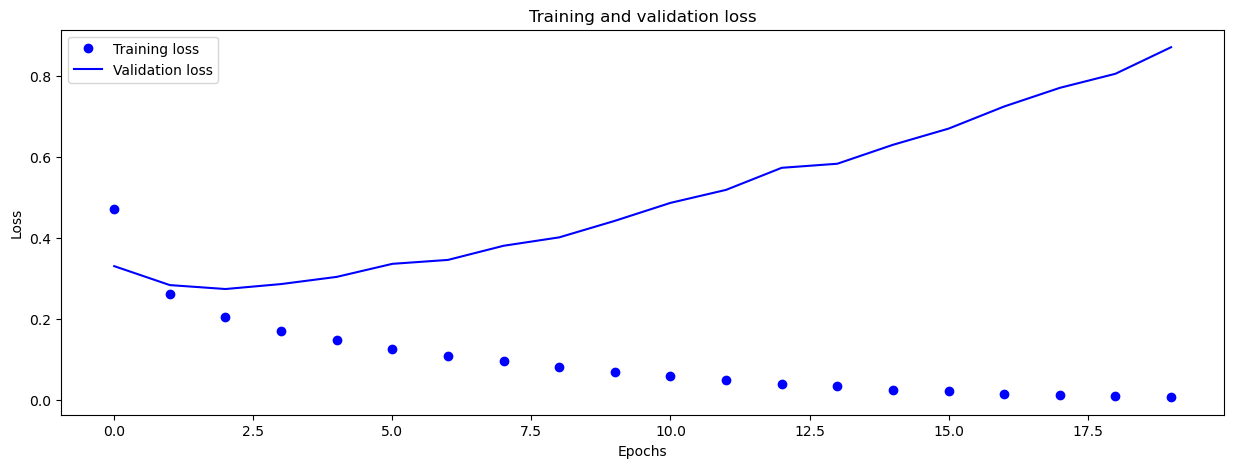

In [24]:
loss1 = history1_dict['loss']
val_loss1 = history1_dict['val_loss']

all_losses.append(loss1)
all_val_losses.append(val_loss1)

PlotLossComparison(loss1, val_loss1)

In [25]:
acc1 = history1_dict['accuracy']
val_acc1 = history1_dict['val_accuracy']


all_accs.append(acc1)
all_val_accs.append(val_acc1)
# PlotAccuracyComparison(acc1, val_acc1)

## Zbytnie dopasowanie modelu do danych uczących (overfitting)

Z przedstawionych wykresów wynika, że nasz model zaczyna się zbytnio dopasowywać do danych uczących już trzeciej epoce treningowej. Mówimy, że ma dużą wariancję. Strata treningowa spada, a dokładność treningu wzrasta, strata walidacyjna rośnie, a dokładność walidacyjna spada.

Oznacza to, że nasz model nie jest wystarczająco dobry dla tego zbioru danych. Projektant powinien być w stanie poradzić sobie z takimi problemami i zrekonstruować model tak, aby jak najbardziej zmniejszyć wariancję, osiągając dobrą właściwość uogólniania modelu. W odwrotnym przypadku model będzie bezużyteczny!

Co możemy zrobić, aby zwiększyć wydajność modelu na danych walidacyjnych?

Spróbuj użyć:
* mniej (1) lub więcej (3 lub 4) warstw ukrytych;
* w warstwach zmniejsz lub zwiększ liczbę jednostek ukrytych (neuronów), np.: 16, 32 lub 64 jednostki;
* innej funkcji straty `mse` zamiast `binary_crossentropy`;
* innej funkcji aktywacji, np. `tanh` lub `elu` zamiast `relu`;
* zwiększ liczbę danych treningowych;
i zobacz, jak wpływa to na walidację i dokładność testów.

Wykonaj te zmiany osobno, aby zauważyć, która zmiana (którego hiperparametru) poprawia wyniki, a która wręcz przeciwnie go psuje?

In [26]:
model2 = models.Sequential()
model2.add(layers.Dense(8, activation='relu', input_shape=(num_top_words,)))
model2.add(layers.Dense(8, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8)                 56008     
                                                                 
 dense_4 (Dense)             (None, 8)                 72        
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 56,089
Trainable params: 56,089
Non-trainable params: 0
_________________________________________________________________


In [27]:
model2.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),   # 'rmsprop'
               loss='binary_crossentropy',
               metrics=['accuracy'])

In [28]:
history2 = model2.fit(partial_x_train,
                      partial_y_train,
                      epochs=20,
                      batch_size=256,
                      validation_data=(x_val, y_val))
history2_dict = history2.history
history2_dict.keys()

Epoch 1/20
71/71 [==============================] - 1s 8ms/step - loss: 0.5513 - accuracy: 0.7617 - val_loss: 0.4455 - val_accuracy: 0.8666
Epoch 2/20
71/71 [==============================] - 0s 5ms/step - loss: 0.3505 - accuracy: 0.8982 - val_loss: 0.3244 - val_accuracy: 0.8811
Epoch 3/20
71/71 [==============================] - 0s 5ms/step - loss: 0.2435 - accuracy: 0.9227 - val_loss: 0.2842 - val_accuracy: 0.8904
Epoch 4/20
71/71 [==============================] - 0s 5ms/step - loss: 0.1941 - accuracy: 0.9361 - val_loss: 0.2839 - val_accuracy: 0.8879
Epoch 5/20
71/71 [==============================] - 0s 5ms/step - loss: 0.1653 - accuracy: 0.9451 - val_loss: 0.2853 - val_accuracy: 0.8891
Epoch 6/20
71/71 [==============================] - 0s 5ms/step - loss: 0.1421 - accuracy: 0.9514 - val_loss: 0.3034 - val_accuracy: 0.8860
Epoch 7/20
71/71 [==============================] - 0s 6ms/step - loss: 0.1243 - accuracy: 0.9600 - val_loss: 0.3146 - val_accuracy: 0.8850
Epoch 8/20
71/71 [==

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

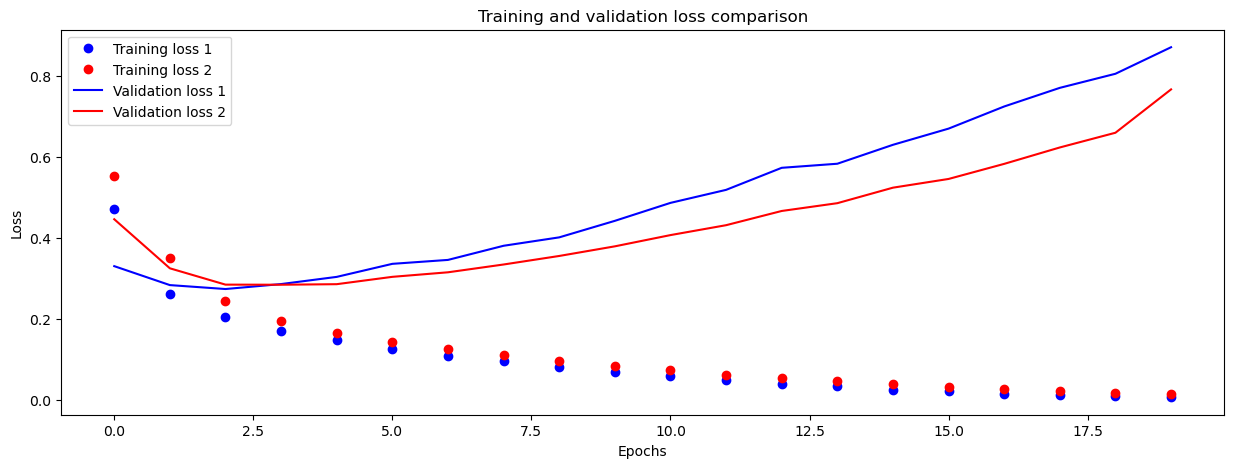

In [29]:
loss1 = history1_dict['loss']
loss2 = history2_dict['loss']
val_loss1 = history1_dict['val_loss']
val_loss2 = history2_dict['val_loss']

all_losses.append(loss2)
all_val_losses.append(val_loss2)

PlotTwoLossComparison(loss1, val_loss1, loss2, val_loss2)

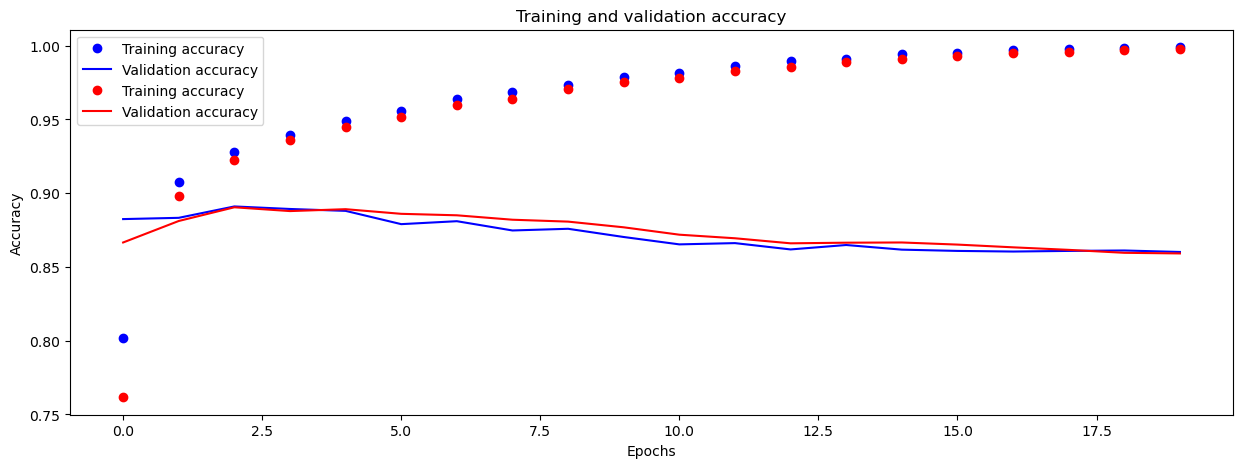

In [30]:
acc2 = history2_dict['accuracy']
val_acc2 = history2_dict['val_accuracy']

all_accs.append(acc2)
all_val_accs.append(val_acc2)

PlotTwoAccuracyComparison(acc1, val_acc1, acc2, val_acc2)

## Model 3

In [31]:
model3 = models.Sequential()
model3.add(layers.Dense(32, activation='relu', input_shape=(num_top_words,)))
model3.add(layers.Dense(32, activation='relu'))
model3.add(layers.Dense(16, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))

In [32]:
model3.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),   # 'rmsprop'
               loss='mse',
               metrics=['accuracy'])

In [33]:
history3 = model3.fit(partial_x_train,
                      partial_y_train,
                      epochs=20,
                      batch_size=256,
                      validation_data=(x_val, y_val))

Epoch 1/20
71/71 [==============================] - 1s 10ms/step - loss: 0.1366 - accuracy: 0.8192 - val_loss: 0.0891 - val_accuracy: 0.8873
Epoch 2/20
71/71 [==============================] - 0s 7ms/step - loss: 0.0713 - accuracy: 0.9079 - val_loss: 0.0873 - val_accuracy: 0.8827
Epoch 3/20
71/71 [==============================] - 0s 7ms/step - loss: 0.0539 - accuracy: 0.9320 - val_loss: 0.0852 - val_accuracy: 0.8881
Epoch 4/20
71/71 [==============================] - 0s 7ms/step - loss: 0.0429 - accuracy: 0.9468 - val_loss: 0.0885 - val_accuracy: 0.8859
Epoch 5/20
71/71 [==============================] - 0s 6ms/step - loss: 0.0351 - accuracy: 0.9578 - val_loss: 0.0986 - val_accuracy: 0.8727
Epoch 6/20
71/71 [==============================] - 0s 7ms/step - loss: 0.0270 - accuracy: 0.9688 - val_loss: 0.0969 - val_accuracy: 0.8774
Epoch 7/20
71/71 [==============================] - 0s 7ms/step - loss: 0.0208 - accuracy: 0.9773 - val_loss: 0.0984 - val_accuracy: 0.8790
Epoch 8/20
71/71 [=

Jakie wyniki są przechowywane w obiekcie `History`?

In [34]:
history3_dict = history3.history
history3_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Przyjrzyjmy się, jak zmieniają się straty (`loss`) i dokładność (`accuracy`) dla danych treningowych i testowych podczas treningu sieci:

In [35]:
loss3 = history3_dict['loss']
val_loss3 = history3_dict['val_loss']
acc3 = history3_dict['accuracy']
val_acc3 = history3_dict['val_accuracy']


all_accs.append(acc3)
all_val_accs.append(val_acc3)
all_losses.append(loss3)
all_val_losses.append(val_loss3)

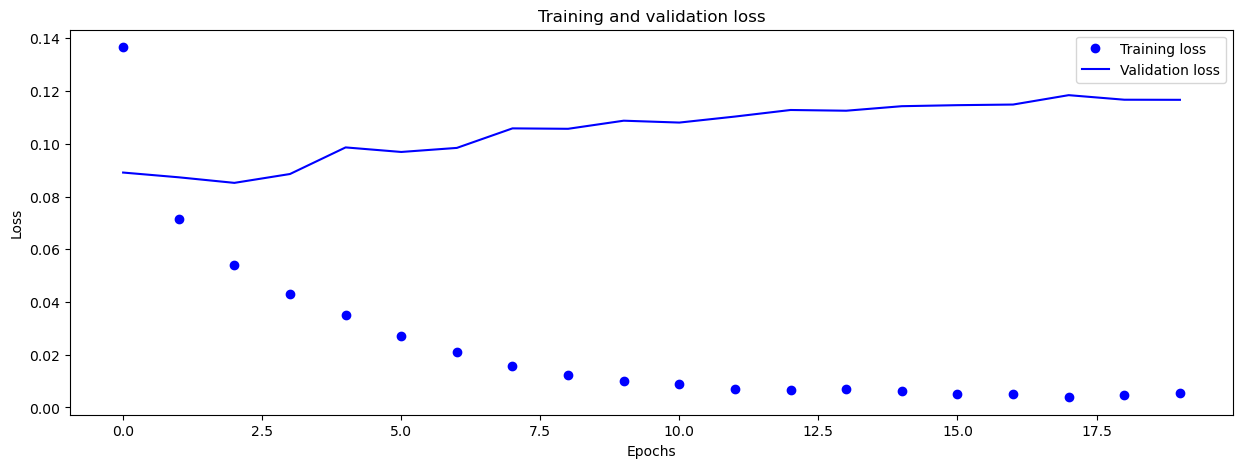

In [36]:
PlotLossComparison(loss3, val_loss3)

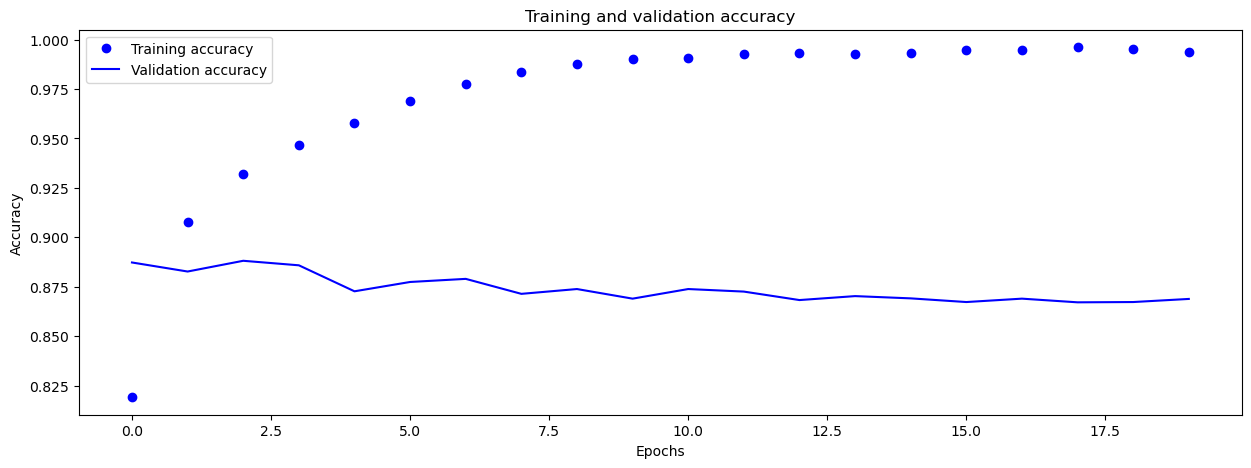

In [37]:
PlotAccuracyComparison(acc3, val_acc3)

#### Dodanie kolejnej warstwy ukrytej o 64 neuronach prowadzi do jeszcze większego overfittingu. Dokładność na danych treningowych dochodzi dość szybko do ~99%, natomiast na danych walidacyjnych oscyluje wokół 87%. <br>Występuje wysoka wariancja. Praktycznie przez cały okres uczenia dokładność  oraz strata walidacyjna pozostają bez zmian.

## Model 4

In [38]:
model4 = models.Sequential()
model4.add(layers.Dense(64, activation='relu', input_shape=(num_top_words,)))
model4.add(layers.Dense(1, activation='sigmoid'))

model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 64)                448064    
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 448,129
Trainable params: 448,129
Non-trainable params: 0
_________________________________________________________________


Do klasyfikacji binarnej możemy użyć `binary_crossentropy` jako funkcji straty:

In [39]:
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import RMSprop

model4.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),   # 'rmsprop'
               loss='binary_crossentropy',
               metrics=['accuracy'])

In [40]:
history4 = model4.fit(partial_x_train,
                      partial_y_train,
                      epochs=20,
                      batch_size=128,
                      validation_data=(x_val, y_val))

Epoch 1/20
141/141 [==============================] - 2s 9ms/step - loss: 0.3517 - accuracy: 0.8557 - val_loss: 0.2889 - val_accuracy: 0.8847
Epoch 2/20
141/141 [==============================] - 1s 6ms/step - loss: 0.2154 - accuracy: 0.9167 - val_loss: 0.2963 - val_accuracy: 0.8831
Epoch 3/20
141/141 [==============================] - 1s 8ms/step - loss: 0.1742 - accuracy: 0.9338 - val_loss: 0.3026 - val_accuracy: 0.8831
Epoch 4/20
141/141 [==============================] - 1s 6ms/step - loss: 0.1393 - accuracy: 0.9483 - val_loss: 0.3302 - val_accuracy: 0.8796
Epoch 5/20
141/141 [==============================] - 1s 6ms/step - loss: 0.1170 - accuracy: 0.9559 - val_loss: 0.3537 - val_accuracy: 0.8796
Epoch 6/20
141/141 [==============================] - 1s 6ms/step - loss: 0.0951 - accuracy: 0.9660 - val_loss: 0.3963 - val_accuracy: 0.8720
Epoch 7/20
141/141 [==============================] - 1s 6ms/step - loss: 0.0749 - accuracy: 0.9733 - val_loss: 0.4321 - val_accuracy: 0.8724
Epoch 

Jakie wyniki są przechowywane w obiekcie `History`?

In [41]:
history4_dict = history4.history
history4_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Przyjrzyjmy się, jak zmieniają się straty (`loss`) i dokładność (`accuracy`) dla danych treningowych i testowych podczas treningu sieci:

In [42]:
loss4 = history4_dict['loss']
val_loss4 = history4_dict['val_loss']
acc4 = history1_dict['accuracy']
val_acc4 = history1_dict['val_accuracy']


all_accs.append(acc4)
all_val_accs.append(val_acc4)
all_losses.append(loss4)
all_val_losses.append(val_loss4)

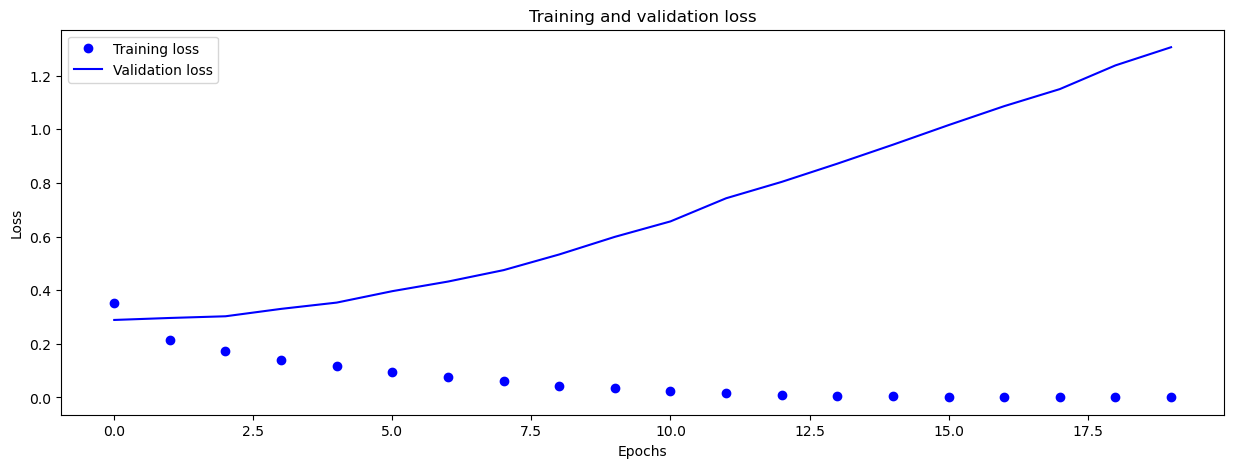

In [43]:
PlotLossComparison(loss4, val_loss4)

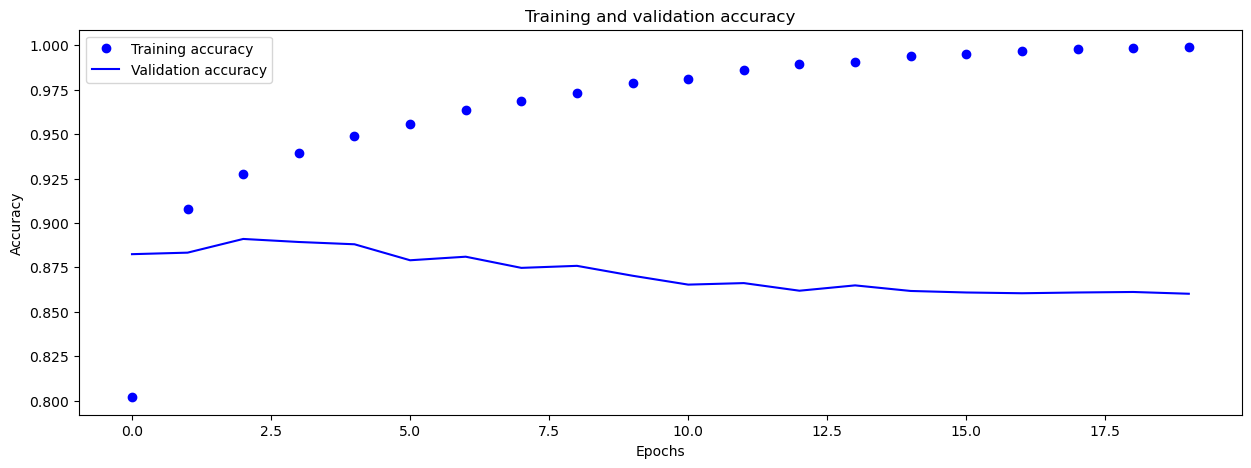

In [44]:
PlotAccuracyComparison(acc4, val_acc4)

### Zmniejszenie ilości warstw ukrytych oraz nauczenie sieci przy dwukrotnie większej ilości epok także nie przyniosło zadowalających skutków. Szybko dochodzi do overfittingu.

### Pora poeksperymentować z wartościami funkcji straty oraz funkcji aktywacji

## Model 5

In [45]:
model5 = models.Sequential()
model5.add(layers.Dense(8, activation='elu', input_shape=(num_top_words,)))
model5.add(layers.Dense(8, activation='elu'))
model5.add(layers.Dense(1, activation='sigmoid'))

model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 8)                 56008     
                                                                 
 dense_13 (Dense)            (None, 8)                 72        
                                                                 
 dense_14 (Dense)            (None, 1)                 9         
                                                                 
Total params: 56,089
Trainable params: 56,089
Non-trainable params: 0
_________________________________________________________________


In [46]:
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import RMSprop

model5.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),   # 'rmsprop'
               loss='binary_crossentropy',
               metrics=['accuracy'])

In [47]:
history5 = model5.fit(partial_x_train,
                      partial_y_train,
                      epochs=20,
                      batch_size=256,
                      validation_data=(x_val, y_val))

Epoch 1/20
71/71 [==============================] - 1s 9ms/step - loss: 0.4425 - accuracy: 0.8253 - val_loss: 0.3283 - val_accuracy: 0.8799
Epoch 2/20
71/71 [==============================] - 0s 5ms/step - loss: 0.2571 - accuracy: 0.9102 - val_loss: 0.2780 - val_accuracy: 0.8891
Epoch 3/20
71/71 [==============================] - 0s 5ms/step - loss: 0.1959 - accuracy: 0.9283 - val_loss: 0.2750 - val_accuracy: 0.8899
Epoch 4/20
71/71 [==============================] - 0s 6ms/step - loss: 0.1609 - accuracy: 0.9416 - val_loss: 0.3047 - val_accuracy: 0.8880
Epoch 5/20
71/71 [==============================] - 0s 5ms/step - loss: 0.1390 - accuracy: 0.9520 - val_loss: 0.3157 - val_accuracy: 0.8854
Epoch 6/20
71/71 [==============================] - 0s 5ms/step - loss: 0.1200 - accuracy: 0.9578 - val_loss: 0.3635 - val_accuracy: 0.8790
Epoch 7/20
71/71 [==============================] - 0s 5ms/step - loss: 0.1063 - accuracy: 0.9648 - val_loss: 0.3766 - val_accuracy: 0.8793
Epoch 8/20
71/71 [==

Jakie wyniki są przechowywane w obiekcie `History`?

In [48]:
history5_dict = history5.history
history5_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Przyjrzyjmy się, jak zmieniają się straty (`loss`) i dokładność (`accuracy`) dla danych treningowych i testowych podczas treningu sieci:

In [49]:
loss5 = history5_dict['loss']
val_loss5 = history5_dict['val_loss']
acc5 = history5_dict['accuracy']
val_acc5 = history5_dict['val_accuracy']


all_accs.append(acc5)
all_val_accs.append(val_acc5)
all_losses.append(loss5)
all_val_losses.append(val_loss5)

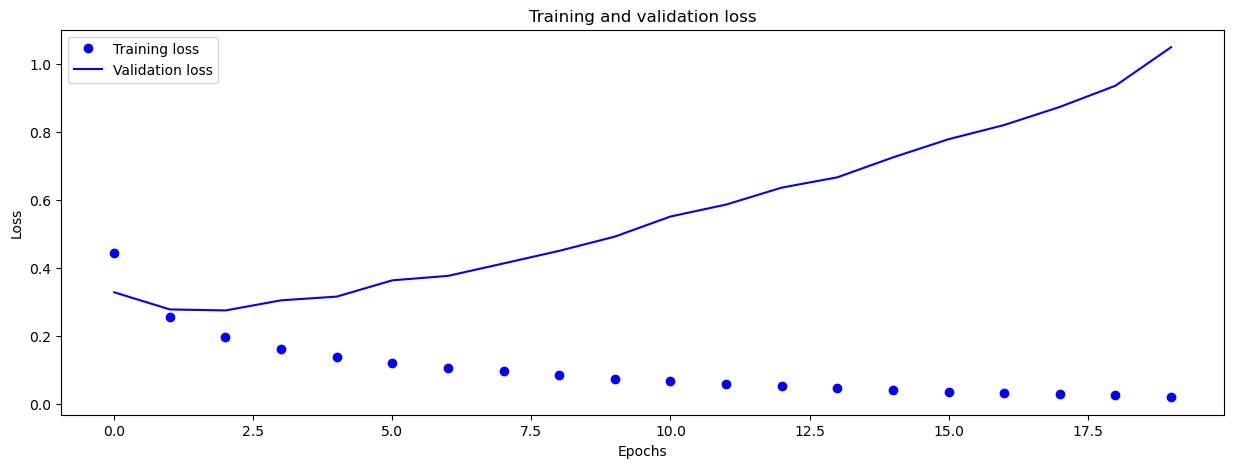

In [50]:
PlotLossComparison(loss5, val_loss5)

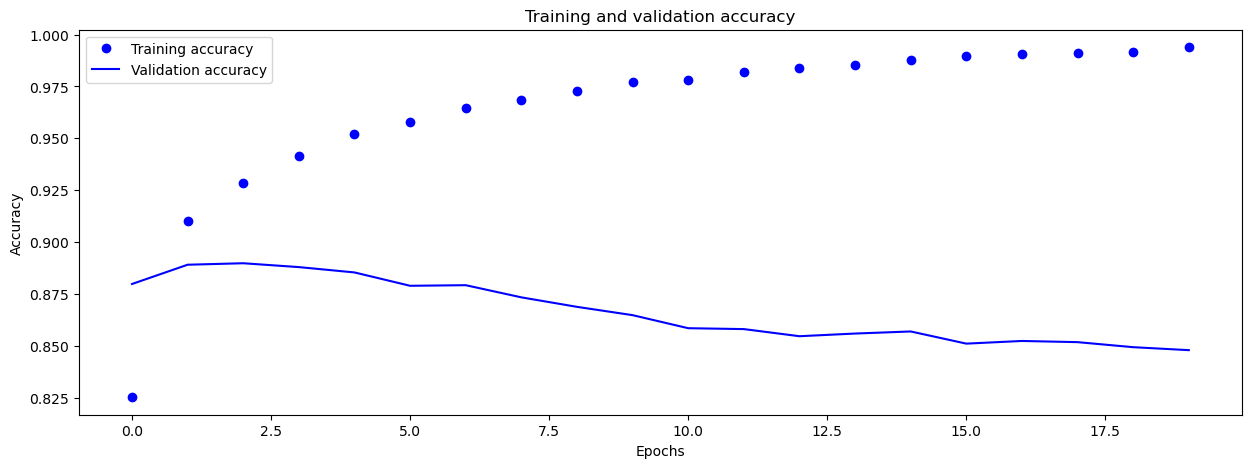

In [51]:
PlotAccuracyComparison(acc5, val_acc5)

#### Przejście z Relu na Elu także nie przynosi oczekiwanych rezultatów - nadal występuje rozbieżność pomiędzy wynikami ze zbioru testowego oraz walidacyjnego.

## Model 6

In [52]:
model6 = models.Sequential()
model6.add(layers.Dense(32, activation='elu', input_shape=(num_top_words,)))
model6.add(layers.Dense(16, activation='sigmoid'))
model6.add(layers.Dense(1, activation='sigmoid'))

model6.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 32)                224032    
                                                                 
 dense_16 (Dense)            (None, 16)                528       
                                                                 
 dense_17 (Dense)            (None, 1)                 17        
                                                                 
Total params: 224,577
Trainable params: 224,577
Non-trainable params: 0
_________________________________________________________________


In [53]:
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import RMSprop

model6.compile(optimizer=optimizers.RMSprop(learning_rate=0.002),   # 'rmsprop'
               loss='binary_crossentropy',
               metrics=['accuracy'])

In [54]:
history6 = model6.fit(partial_x_train,
                      partial_y_train,
                      epochs=20,
                      batch_size=256,
                      validation_data=(x_val, y_val))

Epoch 1/20
71/71 [==============================] - 1s 10ms/step - loss: 0.4164 - accuracy: 0.8381 - val_loss: 0.3053 - val_accuracy: 0.8880
Epoch 2/20
71/71 [==============================] - 0s 6ms/step - loss: 0.2411 - accuracy: 0.9169 - val_loss: 0.2943 - val_accuracy: 0.8817
Epoch 3/20
71/71 [==============================] - 1s 7ms/step - loss: 0.1876 - accuracy: 0.9367 - val_loss: 0.3042 - val_accuracy: 0.8831
Epoch 4/20
71/71 [==============================] - 1s 14ms/step - loss: 0.1570 - accuracy: 0.9483 - val_loss: 0.3188 - val_accuracy: 0.8831
Epoch 5/20
71/71 [==============================] - 1s 8ms/step - loss: 0.1379 - accuracy: 0.9551 - val_loss: 0.3900 - val_accuracy: 0.8674
Epoch 6/20
71/71 [==============================] - 0s 7ms/step - loss: 0.1193 - accuracy: 0.9638 - val_loss: 0.3784 - val_accuracy: 0.8716
Epoch 7/20
71/71 [==============================] - 1s 7ms/step - loss: 0.1072 - accuracy: 0.9676 - val_loss: 0.3896 - val_accuracy: 0.8751
Epoch 8/20
71/71 [

In [55]:
history6_dict = history6.history
history6_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [56]:
loss6 = history6_dict['loss']
val_loss6 = history6_dict['val_loss']
acc6 = history6_dict['accuracy']
val_acc6 = history6_dict['val_accuracy']


all_accs.append(acc6)
all_val_accs.append(val_acc6)
all_losses.append(loss6)
all_val_losses.append(val_loss6)

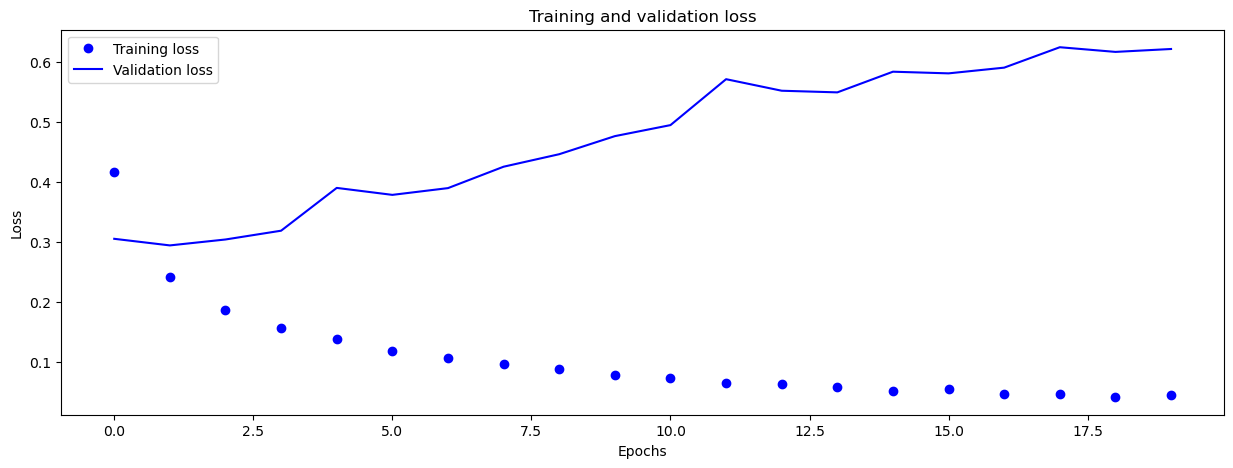

In [57]:
PlotLossComparison(loss6, val_loss6)

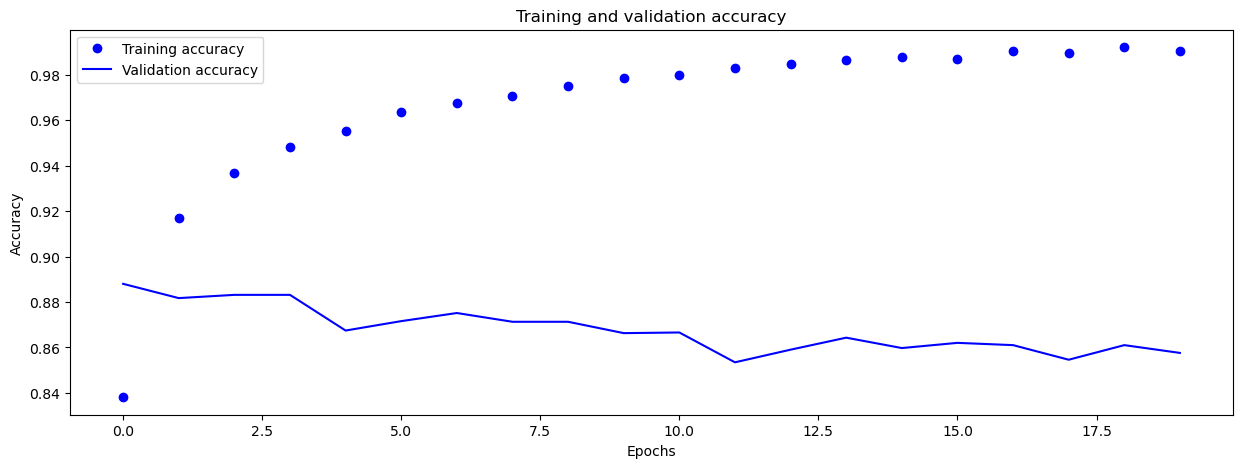

In [58]:
PlotAccuracyComparison(acc6, val_acc6)

## Plot all results on one plot

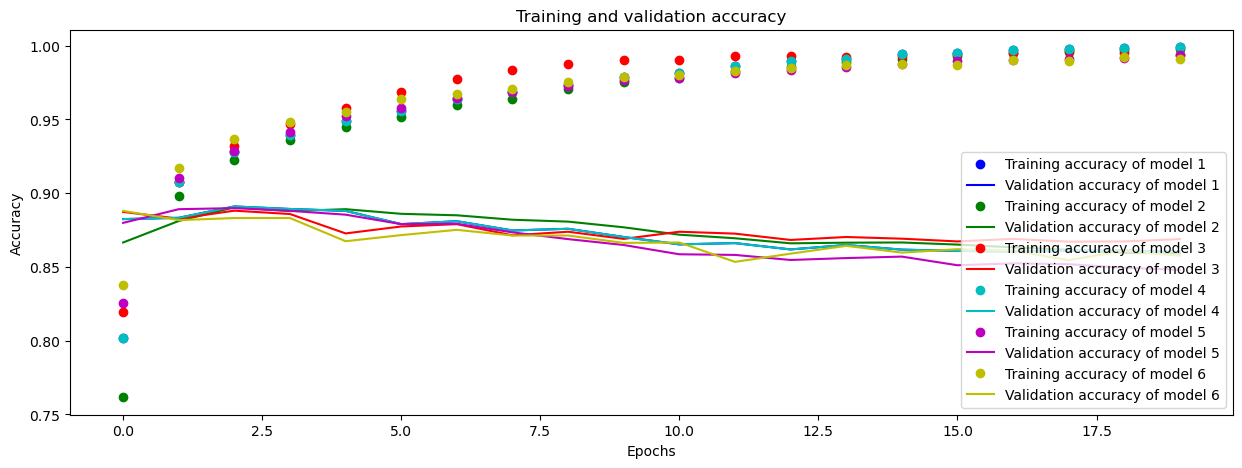

In [59]:
PlotMultipleAccuracyComparison(all_accs, all_val_accs)

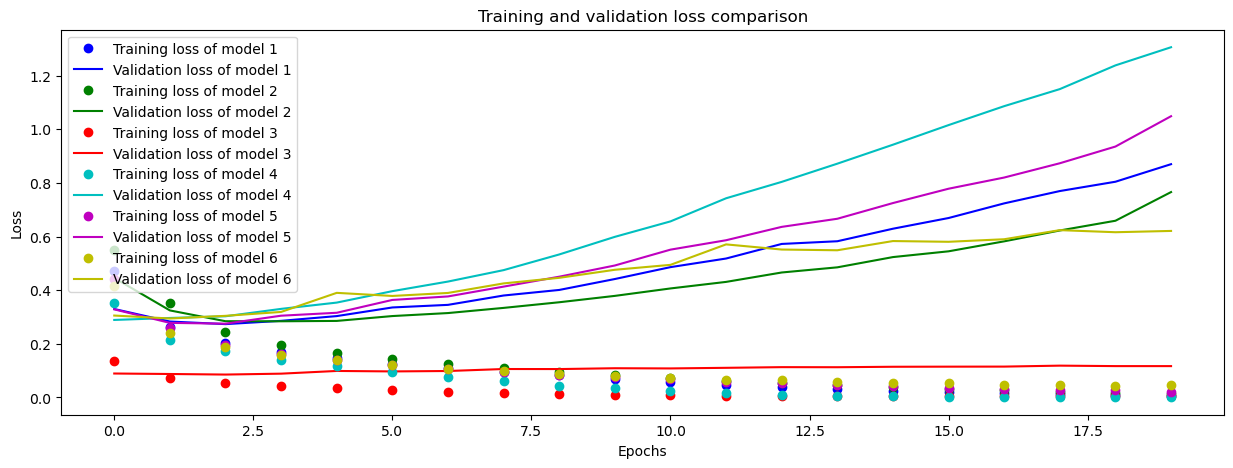

In [60]:
PlotMultipleLossComparison(all_losses, all_val_losses)

#### Wstępne testy nie przynosza oczekiwanych rezultatów. Dokładność na walidacyjnym zbiorze danych dla wszystkich modeli jest bardzo podobna.

Jak widać na wykresie modele przynoszą największą dokładność przy 1 lub 2 epoce. Później wyniki coraz bardziej się rozbiegają - dokładność na zbiorze treningowym wzrastsa, natomiast dokładność na zbiorze walidacyjnym pozostaje taka sama lub maleje. Wzrasta wtedy wariancja modeli. 

In [61]:
second_epoch_results = [res[2] for res in all_val_accs]
second_epoch_results

[0.890999972820282,
 0.8904285430908203,
 0.8881428837776184,
 0.890999972820282,
 0.8898571133613586,
 0.8831428289413452]

Największa dokładność na zbiorze walidacyjnym występuje właśnie przy 2. epoce, którą osiąga czwarty model. Pozostałe modele jednak nie odbiegają znacznie od tego wyniku.

In [62]:
np.array(all_val_accs).max()

0.890999972820282

In [63]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 64)                448064    
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 448,129
Trainable params: 448,129
Non-trainable params: 0
_________________________________________________________________


Zauważalnie niski błąd walidacyjny w porównaniu do pozostałych modeli posiada model 3. Jest to spowodowane tym, że model 3 korzysta z funkcji straty `Mean Squared Error (MSE)`.
<br> Prowadzi to do wniosku, że mierzenie jest niemiarodajne gdy zastosujemy do porównywanych modeli innnych funkcji straty (porównując wyniki na jednym wykresie).
<br> Co ciekawe po zmianie funkcji straty z `MSE` na `binary_crossentropy` okazuje się że dla tego modelu strata jest największa spośród rozpatrywanych przypadków.

#### Po przetestowaniu kilku architektur z różnymi parametrami nadal nie udało się otrzymać wyniku 90% lub większej dokładności (w przypadku GridSearch na zbiorze testowym) . Najczęściej wyniki wahają się pomiędzy 88-89%.

Próbowanie każdej opcji na osobnym modelu jest wolne i nie widać większych różnic pomiędzy modelami mimo zmiany parametrów, więc postanowiłem użyć GridSearchCV, aby automatycznie uzyskać porównanie wyników dla wielu wariantów parametrów zmieniając przy tym architekturę sieci.
## GridSearchCV

In [102]:
# Use scikit-learn to grid search the activation function
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier


def print_results(grid_result):
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    print("MEAN_TEST_SCORE - STD_TEST_SCORE - PARAMS")
    for mean, stdev, param in zip(means, stds, params):
        print(f"{mean} ({stdev}) with: {param}")

### Test different activation functions in NN with 4 layers - 64, 24, 8, 1 neurons

In [99]:
# Function to create model, required for KerasClassifier
def create_model(activation='relu'):
    # create model
    model = Sequential()
    model.add(layers.Dense(64, activation=activation, input_shape=(num_top_words,)))
    model.add(layers.Dense(24, activation=activation))
    model.add(layers.Dense(8, activation=activation))
    model.add(layers.Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(
        loss='mse', 
        optimizer=optimizers.RMSprop(learning_rate=0.015), 
        metrics=['accuracy'])
    return model


In [100]:
# create model
model = KerasClassifier(model=create_model, epochs=5, batch_size=256, verbose=1)
# define the grid search parameters
activation = ['softmax', 'relu', 'tanh', 'sigmoid', 'elu']
param_grid = dict(model__activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, verbose=0)

In [101]:
grid_result = grid.fit(x_train, y_train)

print_results(grid_result)

Epoch 1/5
49/49 [==============================] - 1s 8ms/step - loss: 0.2179 - accuracy: 0.7245
Epoch 2/5
49/49 [==============================] - 0s 8ms/step - loss: 0.1062 - accuracy: 0.9077
Epoch 3/5
49/49 [==============================] - 0s 9ms/step - loss: 0.0683 - accuracy: 0.9269
Epoch 4/5
49/49 [==============================] - 0s 8ms/step - loss: 0.0557 - accuracy: 0.9385
Epoch 5/5
49/49 [==============================] - 0s 4ms/step
Epoch 1/5
49/49 [==============================] - 2s 7ms/step - loss: 0.2186 - accuracy: 0.7386
Epoch 2/5
49/49 [==============================] - 0s 7ms/step - loss: 0.1076 - accuracy: 0.9026
Epoch 3/5
49/49 [==============================] - 0s 7ms/step - loss: 0.0648 - accuracy: 0.9310
Epoch 4/5
49/49 [==============================] - 0s 8ms/step - loss: 0.0486 - accuracy: 0.9474
Epoch 5/5
49/49 [==============================] - 0s 4ms/step
Epoch 1/5
49/49 [==============================] - 1s 7ms/step - loss: 0.1778 - accuracy: 0.7612
E

W zależności od tego czy wykonujemy regresję lub klasyfikację na warstwie wyjściowej wymagana jest odpowiednia funkcja aktywacji. 

W warstwie wyjściowej dla klasyfikacji binarnej można zastosować funkcję sigmoid, której wyjścia znajdują się w przedziale [0, 1], dzięki czemu wyjścia mogą być interpretowane jako prawdopodobieństwo należenia do określonej klasy (wartość prawdopodobieństwa).

Na przykład przy użyciu softmax na wyjściu przy klasyfikacji binarnej otrzymujemy accuracy na poziomie około 50% co nie posiada większego sensu. Softmax ma zastosowanie przy klasyfikacji wieloklasowej, w której otrzymujemy prawdopodobieństwo przynależności odpowiednio dla każdej klasy. Wszystkie otrzymane prawdopodobieństwa sumują się do 1 (100%). Dodatkowo, w tym wypadku trzeba by było zmienić ilość neuronów w warstwie wyjściowej, ponieważ przy użyciu softmax ilość neuronów w warstiwe wyjściowej powinna odpowiadać ilości klas, które rozpatrujemy w klasyfikacji. Także dla 1 neurona w warstwie wyjściowej ustawiłem "na sztywno" funkcję sigmoid, ponieważ inne z nich nie przynosiły zadowalających rezultatów (tak jak wspominałem: softmax miał accuracy 50%, więc konstrukcja nie była w pełni poprawna).

Dlatego ważne jest aby w zależności od celu który chcemy osiągnąć poprawnie dobrać funkcje aktywacji warstwy wyjściowej - jest to podstawowa informacja lecz na pewno warta wspomnienia. W przypadku klasyfikacji binarnej odpowiednią opcją jest np. sigmoid.

# Przykład regresji

## Zbiór danych Boston Housing Price

Zademonstrujemy regresję, próbując przewidzieć medianę cen domów na danym przedmieściu Bostonu w połowie lat 70., biorąc pod uwagę kilka danych dotyczących tego przedmieścia w tym czasie, takich jak wskaźnik przestępczości, stawka lokalnego podatku od nieruchomości itp.

Do treningu będziemy mieli bardzo mało przykładów danych, tylko 506 łącznie, podzielone na 404 przykłady treningowe i 102 przykłady testowe, a każda „cecha” w danych wejściowych (np. wskaźnik przestępczości jest cechą) ma inną skalę. Na przykład niektóre wartości są proporcjami, które przyjmują wartości od 0 do 1, inne przyjmują wartości od 1 do 12, inne od 0 do 100 itd.

#### Imports

In [63]:
from tensorflow.keras import models
from tensorflow.keras import layers
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import RMSprop

# Plot training & validation accuracy values: https://keras.io/visualization/#training-history-visualization
plt.rcParams['figure.figsize'] = (15.0, 5.0) # set default size of plots

In [143]:
import os
import numpy as np
import random

# fix random seed for reproducibility
seed = 42
tf.random.set_seed(seed)

def set_seeds(seed=seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

set_seeds(42)

In [ ]:
#get consistent results
from keras.models import Sequential
from keras.layers import Dense
import numpy
from numpy.random import seed
seed(42)

In [65]:
# needed to solve the problem with out of GPU memory error 
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

### Zadanie

Skopiuj i wklej powyższy kod i spróbuj więcej eksperymentować z dostępnymi hiperparametrami tego modelu, aby osiągnąć jeszcze lepszą wydajność!

In [68]:
from tensorflow.keras import models
from tensorflow.keras import layers
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import RMSprop

# Plot training & validation accuracy values: https://keras.io/visualization/#training-history-visualization
plt.rcParams['figure.figsize'] = (15.0, 5.0) # set default size of plots

In [69]:
# fix random seed for reproducibility
# seed = 7
# tf.random.set_seed(seed)

In [70]:
import tensorflow as tf
# needed to solve the problem with out of GPU memory error 
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

### Prepare data 

In [71]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

In [72]:
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

train_data -= mean
train_data /= std

test_data -= mean
test_data /= std

## Budowanie sieci

Ponieważ dostępnych jest tak mało próbek, będziemy używać bardzo małej sieci z dwiema ukrytymi warstwami, każda po 32 jednostki. Ogólnie rzecz biorąc, im mniej danych treningowych posiadasz, tym gorsze będzie nadmierne dopasowanie sieci (przeuczenie), a korzystanie z małej sieci jest jednym ze sposobów na złagodzenie nadmiernego dopasowania.

In [136]:
def build_model():
    # Because we will need to instantiate the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(32, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

#### K-Fold validation

In [74]:
# num_epochs = 500
def k_fold_validation(model, k, num_epochs):
    all_mae_histories = []
    num_val_samples = len(train_data) // k
    for i in range(k):
        print('processing fold #', i)
        # Prepare the validation data: data from partition # k
        val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

        # Prepare the training data: data from all other partitions
        partial_train_data = np.concatenate(
            [train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]],
            axis=0)
        partial_train_targets = np.concatenate(
            [train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]],
            axis=0)

        # Build the Keras model (already compiled)
        # model = build_model()
        # Train the model (in silent mode, verbose=0)
        history = model.fit(partial_train_data, partial_train_targets,
                            validation_data=(val_data, val_targets),
                            epochs=num_epochs, batch_size=16, verbose=0)
        #print (history.history.keys())
        #mae_history = history.history['val_mean_absolute_error']
        mae_history = history.history['val_mae']
        all_mae_histories.append(mae_history)
    return all_mae_histories

In [75]:
all_mae_histories = {}

In [76]:
model1 = build_model()

In [77]:
print(model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                448       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________
None


In [78]:
all_mae_histories['model1'] = k_fold_validation(model1, 5, 500)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4


In [79]:
def get_avg_mae_histories_per_epoch(model_mae_histories):
    num_epochs = len(model_mae_histories[0])
    average_mae_history = [np.mean([x[i] for x in model_mae_histories])
                           for i in range(num_epochs)]
    argmin = np.argmin(average_mae_history)    
    print(f"argmin: {argmin}")
    print(f"min mae: {average_mae_history[np.argmin(average_mae_history)]}")
    return average_mae_history, argmin

In [80]:
model1_avg_mae, model1_min_mae_epoch = get_avg_mae_histories_per_epoch(all_mae_histories['model1'])

argmin: 39
min mae: 1.4870589971542358


In [133]:
# def smooth_curve(points, factor=0.9):
#   smoothed_points = []
#   for point in points:
#     if smoothed_points:
#       previous = smoothed_points[-1]
#       smoothed_points.append(previous * factor + point * (1 - factor))
#     else:
#       smoothed_points.append(point)
#   return smoothed_points

def plot_model_mae(average_mae_history, argmin):
    # smooth_mae_history = smooth_curve(average_mae_history[10:])
    # omit 10 becuase of different value scale 
    smooth_mae_history = average_mae_history[10:]
    plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
    plt.axvline(x=argmin, color='r', linewidth=2)
    plt.xlabel('Epochs')
    plt.ylabel('Validation MAE')
    plt.show()

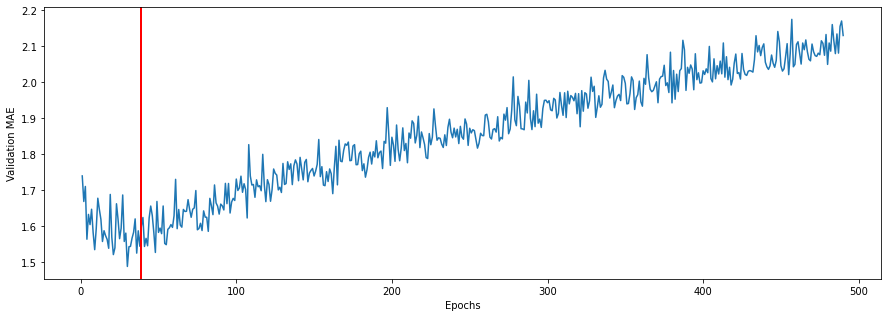

In [134]:
plot_model_mae(model1_avg_mae, model1_min_mae_epoch)

In [83]:
model1_avg_mae[model1_min_mae_epoch]

1.4870589971542358

Na podstawie wykresu można stwierdzić, że ten model przestaje się zbiegać przy epoce o numerze `model_min_mae_epoch` (zaznaczona czerwoną linią) - wtedy wystepuje najnizsza wartosc validation MAE, po tej epoce validation MAE zaczyna wzrastać.

Stworzony zostanie nowy model, który zostanie nauczany przez ilość epok, która dawała najniższą średnią wartość MAE na zbiorze walidacyjnym.

In [144]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
model.fit(train_data, train_targets,
          epochs=model1_min_mae_epoch, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

4/4 [==============================] - 0s 3ms/step - loss: 20.9002 - mae: 3.0518


3.0517890453338623

Model po uczenie przez 39 epok nie daje zadowalających wyników. Sprawdźmy czy jednak przy dłuższym uczeniu jego wyniki się nie polepsza.



In [146]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
model.fit(train_data, train_targets,
          epochs=50, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

4/4 [==============================] - 0s 3ms/step - loss: 22.7989 - mae: 3.0790


3.0790157318115234

Model uczony przez 50 epok daje gorsze wyniki niż ten którego liczba epok jest oparta o wykres MAE na zbiorze walidacyjnym.

Sprawdźmy rezultaty przy 100 epokach.

In [155]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
model.fit(train_data, train_targets,
          epochs=100, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

4/4 [==============================] - 0s 4ms/step - loss: 17.8763 - mae: 2.5644


2.5644309520721436

Mimo tego że najmniejszy błąd na zbiorze walidacyjnym wystąpił na 39 epoce model uczony przez 39 epok działa gorzej niż ten, który uczony został przez 100 epok, co wnioskując po wykresie nie jest do końca oczekiwanym wynikiem. 

Sprawdźmy rezultaty przy 500 epokach.

In [156]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
model.fit(train_data, train_targets,
          epochs=500, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

4/4 [==============================] - 0s 3ms/step - loss: 14.4286 - mae: 2.5519


2.551919937133789

Wynik nieznacznie się zmienił przy 500 epokach - spadła wartość straty, lecz dokładność pozostała praktycznie na tym samym poziomie.


Na podstawie tych obserwacji można stwierdzić że numer epoki, która daje najniższa wartość MAE na zbiorze walidacyjnym nie oznacza jednoznacznie, że jest ona najlepszą opcją. Warto poeksperymentować z ilością epok co pozwoli utworzyć najlepszy model.

Kolejny model jest oparty o model1, dodano do niego jedną warstwę ukrytą zawierającą 32 neurony.

### Model 2

In [157]:
def build_model():
    # Because we will need to instantiate the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(32, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [158]:
model2 = build_model()

In [159]:
print(model2.summary())

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_119 (Dense)           (None, 32)                448       
                                                                 
 dense_120 (Dense)           (None, 32)                1056      
                                                                 
 dense_121 (Dense)           (None, 32)                1056      
                                                                 
 dense_122 (Dense)           (None, 32)                1056      
                                                                 
 dense_123 (Dense)           (None, 1)                 33        
                                                                 
Total params: 3,649
Trainable params: 3,649
Non-trainable params: 0
_________________________________________________________________
None


In [160]:
all_mae_histories['model2'] = k_fold_validation(model2, 5, 500)
model2_avg_mae, model2_min_mae_epoch = get_avg_mae_histories_per_epoch(all_mae_histories['model2'])

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
argmin: 19
min mae: 0.97500439286232


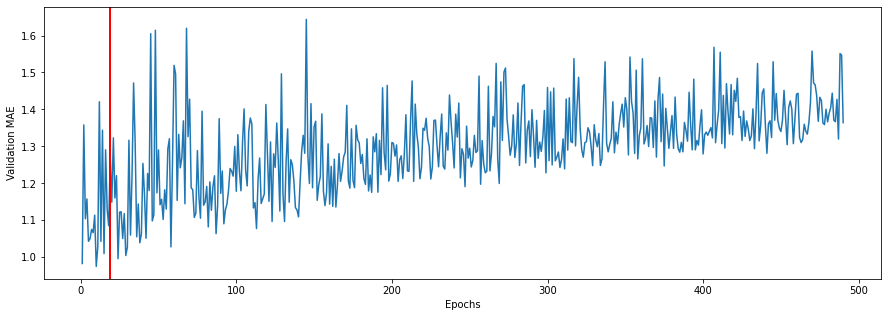

In [161]:
plot_model_mae(model2_avg_mae, model2_min_mae_epoch)

In [162]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
model.fit(train_data, train_targets,
          epochs=model2_min_mae_epoch, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

4/4 [==============================] - 0s 3ms/step - loss: 21.8454 - mae: 3.0973


3.097254753112793

In [163]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

4/4 [==============================] - 0s 3ms/step - loss: 16.9811 - mae: 2.7406


2.7406442165374756

In [170]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
model.fit(train_data, train_targets,
          epochs=250, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

4/4 [==============================] - 0s 5ms/step - loss: 13.2154 - mae: 2.3309


2.3308677673339844

In [165]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
model.fit(train_data, train_targets,
          epochs=500, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

4/4 [==============================] - 0s 4ms/step - loss: 20.4385 - mae: 2.7291


2.7290804386138916

Model 2 osiągnął do tej pory najlepszy wynik z rozpatrywanych konfiguracji. Liczba epok dla której MAE wyniosło 2330$ to 250. (Przeprowadziłem testy dla 80,200, 300, 400, 500, lecz wyniki były gorsze - nie umieściłem ich tutaj, ponieważ zajęłoby to za dużo miejsca).

Na podstawie obserwacji można stwierdzić, że model warto przetestować na różnej ilości epok. Nie tylko tej w otoczeniu najniższego Validation MAE. Aby to zautomatyzować stworzę metodę, która pozwoli zwizualizować wyniki MAE na zbiorze testowym w zależności od ilości epok.  

In [183]:
def plot_MAE_for_epochs(func_build_model: callable, epoch_counts: []):
  results = {}
  for epochs in epoch_counts: 
    # Get a fresh, compiled model.
    model = build_model()
    # Train it on the entirety of the data.
    model.fit(train_data, train_targets,
              epochs=epochs, batch_size=16, verbose=0)
    test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
    results[epochs] = test_mae_score

  # fig = plt.figure(figsize = (10, 5))
  # set bar plot y axis limits 
  min_MAE = min(results.values())
  max_MAE = max(results.values())
  min_y_lim = min_MAE - 0.2 * min_MAE
  max_y_lim = max_MAE + 0.2 * min_MAE
  plt.ylim(min_y_lim, max_y_lim)

  # map list of epochs to strings to make x axis discrete
  epochs_str = list(map(lambda x: str(x), epoch_counts))
  # create  the bar plot
  plt.bar(epochs_str, results.values())
  plt.xlabel("No. of epochs")
  plt.ylabel("Test data MAE")
  plt.show()

4/4 [==============================] - 0s 3ms/step - loss: 14.2584 - mae: 2.5739


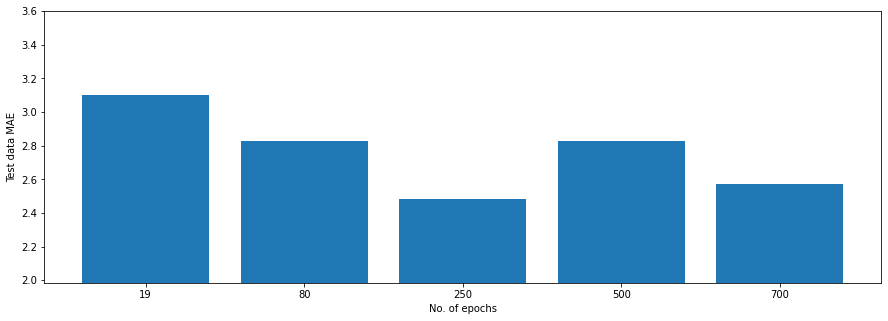

In [185]:
plot_MAE_for_epochs(build_model, [model2_min_mae_epoch, 80, 250, 500, 700])

4/4 [==============================] - 1s 4ms/step - loss: 11.2477 - mae: 2.4985


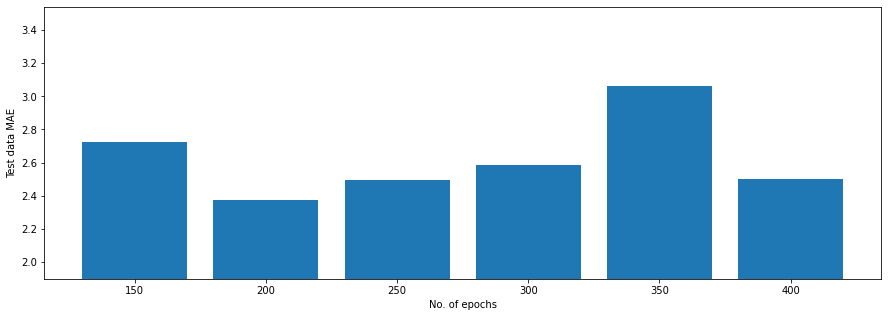

In [186]:
plot_MAE_for_epochs(build_model, [150, 200, 250, 300, 350, 400])

Po kilku próbach widać że najlepszy wynik otrzymujemy ucząc model przez 200 epok, lecz dzięki metodzie która wizualizuje wyniki MAE na zbiorze testowym w łatwy sposób możemy zmniejszyć jeszcze bardziej przedział rozpatrywanych wartości.

4/4 [==============================] - 0s 3ms/step - loss: 15.1974 - mae: 2.6776


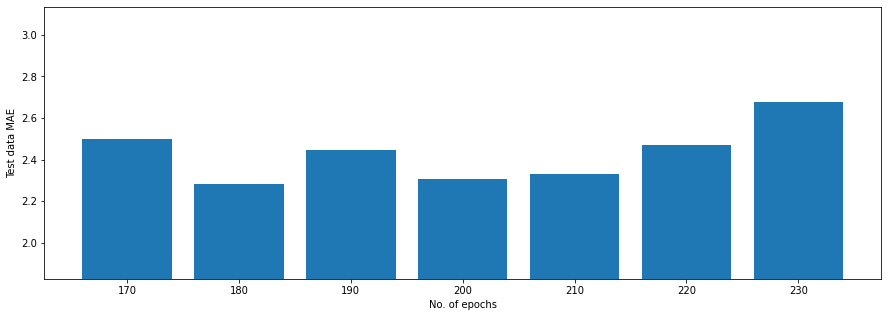

In [187]:
plot_MAE_for_epochs(build_model, [170, 180, 190, 200, 210, 220, 230])

Można uznać że dla tego modelu 180 epok jest optymalnym wyborem. Otrzymujemy wtedy MAE na poziomie ok 2280$.

Pora zacząć zmieniać ilość neuronów w sieci i sprawdzić jakie przyniesie to rezultaty.

### Model 3

In [188]:
def build_model():
    # Because we will need to instantiate the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(128, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(96, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [189]:
model3 = build_model()

In [190]:
print(model3.summary())

Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_374 (Dense)           (None, 128)               1792      
                                                                 
 dense_375 (Dense)           (None, 96)                12384     
                                                                 
 dense_376 (Dense)           (None, 64)                6208      
                                                                 
 dense_377 (Dense)           (None, 32)                2080      
                                                                 
 dense_378 (Dense)           (None, 1)                 33        
                                                                 
Total params: 22,497
Trainable params: 22,497
Non-trainable params: 0
_________________________________________________________________
None


In [191]:
all_mae_histories['model3'] = k_fold_validation(model3, 5, 500)
model3_avg_mae, model3_min_mae_epoch = get_avg_mae_histories_per_epoch(all_mae_histories['model3'])

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
argmin: 24
min mae: 0.899832546710968


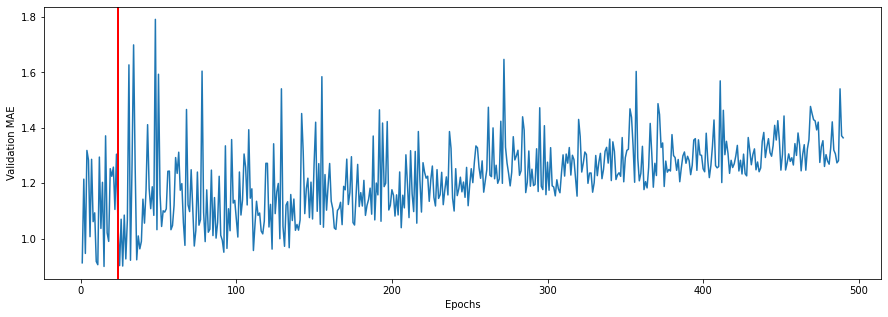

In [192]:
plot_model_mae(model3_avg_mae, model3_min_mae_epoch)

4/4 [==============================] - 0s 4ms/step - loss: 12.6008 - mae: 2.3988


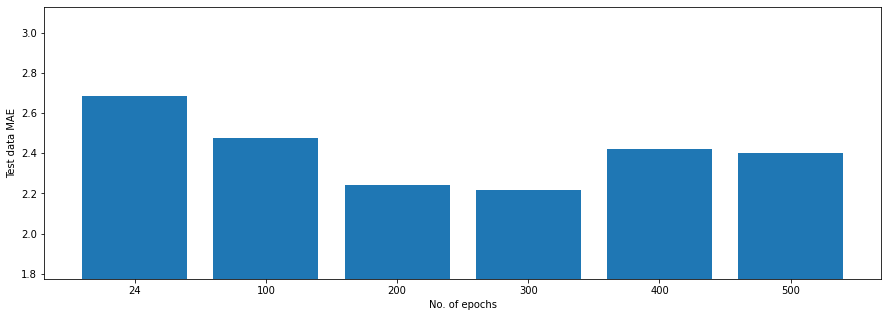

In [222]:
plot_MAE_for_epochs(build_model, [model3_min_mae_epoch, 100, 200, 300, 400, 500])

Najniższa wartość błędu występuje w okolicach 300 epoki. 

Dalsza analiza:

4/4 [==============================] - 0s 3ms/step - loss: 10.7076 - mae: 2.2599


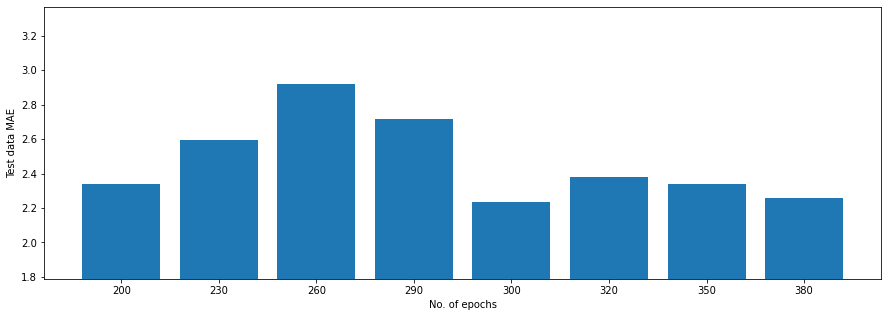

In [219]:
plot_MAE_for_epochs(build_model, [200, 230, 260, 290,300, 320, 350, 380])

Okolice 300 epoki wydają się być najlepszym wyborem. Na diagramie zauważyć też można że przy 200 epoce jest spadek - warto sprawdzić też tamten zakres oraz ponad okolice 380. 

Na podstawie własnych obserwacji podejrzewam, że dobrą opcją może być branie wartości posiadających minimalne wartości MAE na zbiorach walidacyjnych w określonych przedziałach, a nie jednej wartości globalnie na całym zakresie uczenia.


In [205]:
# returns no. of epochs which have the lowest MAE per interval (capacity means how many epochs can interval contain)
def min_MAE_per_interval(mae_history, capacity=50):
  best_epochs_nums = []
  for i in range(len(mae_history) // capacity + 1):
    mae_interval = mae_history[i*capacity:(i+1)*capacity]
    min_mae_num = np.argmin(mae_interval) + i*capacity
    best_epochs_nums.append(min_mae_num)
  return best_epochs_nums

In [220]:
min_MAE_per_interval(model3_avg_mae, 30)

[24,
 36,
 82,
 101,
 120,
 173,
 185,
 215,
 249,
 295,
 328,
 338,
 371,
 394,
 421,
 472,
 487]

4/4 [==============================] - 0s 3ms/step - loss: 17.0688 - mae: 3.1030


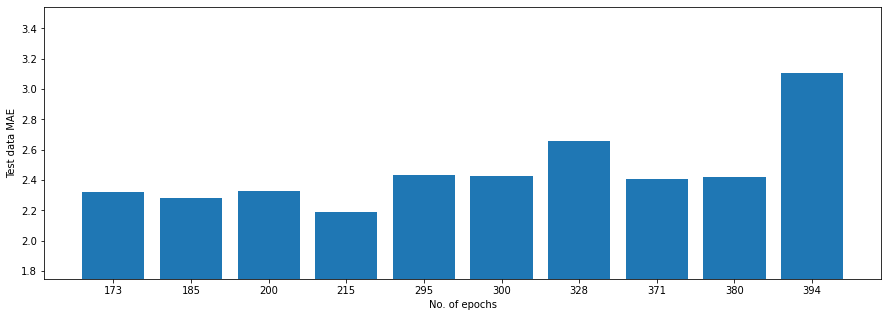

In [221]:
# błędy modeli trenowanych przez wybraną ilość epok z przedziałów: okolice 200, 300 i 380
plot_MAE_for_epochs(build_model,[173, 185, 200, 215, 295, 300, 328, 371, 380, 394])

In [210]:
min_MAE_per_interval(model3_avg_mae, 51)

[24, 101, 120, 173, 215, 258, 328, 371, 421, 472]

4/4 [==============================] - 0s 3ms/step - loss: 11.6247 - mae: 2.2645


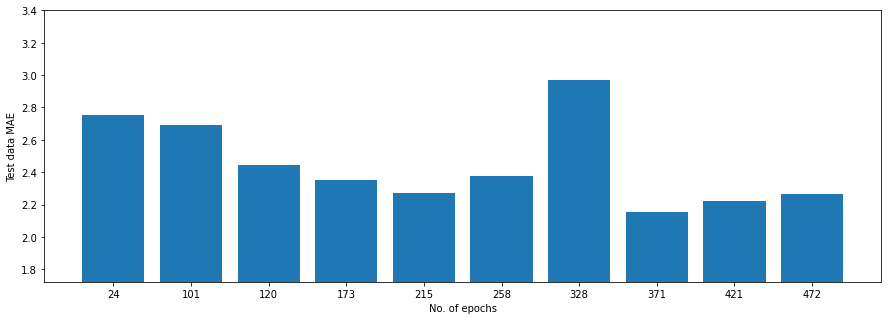

In [214]:
plot_MAE_for_epochs(build_model,[24, 101, 120, 173, 215, 258, 328, 371, 421, 472])

In [ ]:
min_MAE_per_interval(model3_avg_mae, 51)

Finalnie najniższy otrzymany błąd dla tego modelu występuje dla 371 epoki i wynosi 2154$. 

### Model 4

Ten model jest bardzo podobny do poprzedniego. Dodano warstwę wejściową zawierającą 256 neuronów.

In [237]:
def build_model():
    # Because we will need to instantiate the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(256, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(96, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [238]:
model4 = build_model()

In [239]:
print(model4.summary())

Model: "sequential_179"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_895 (Dense)           (None, 256)               3584      
                                                                 
 dense_896 (Dense)           (None, 128)               32896     
                                                                 
 dense_897 (Dense)           (None, 96)                12384     
                                                                 
 dense_898 (Dense)           (None, 64)                6208      
                                                                 
 dense_899 (Dense)           (None, 32)                2080      
                                                                 
 dense_900 (Dense)           (None, 1)                 33        
                                                                 
Total params: 57,185
Trainable params: 57,185
Non-tr

In [240]:
all_mae_histories['model4'] = k_fold_validation(model4, 5, 500)
model4_avg_mae, model4_min_mae_epoch = get_avg_mae_histories_per_epoch(all_mae_histories['model4'])

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
argmin: 19
min mae: 0.8694345355033875


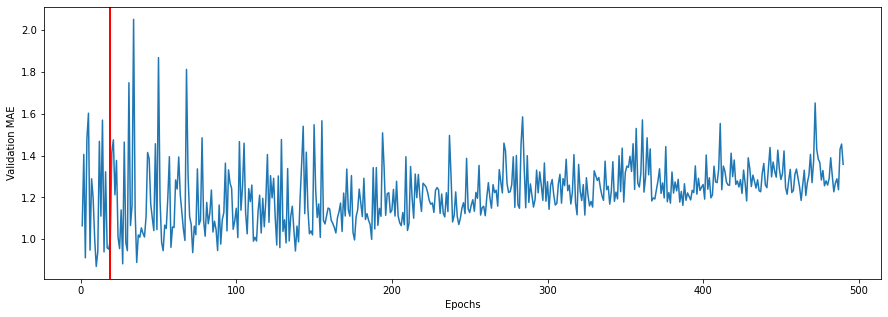

In [241]:
plot_model_mae(model4_avg_mae, model4_min_mae_epoch)

In [242]:
min_MAE_per_interval(model4_avg_mae, 51)

[19, 81, 147, 185, 219, 269, 333, 396, 437, 472]

4/4 [==============================] - 0s 3ms/step - loss: 12.1934 - mae: 2.5078


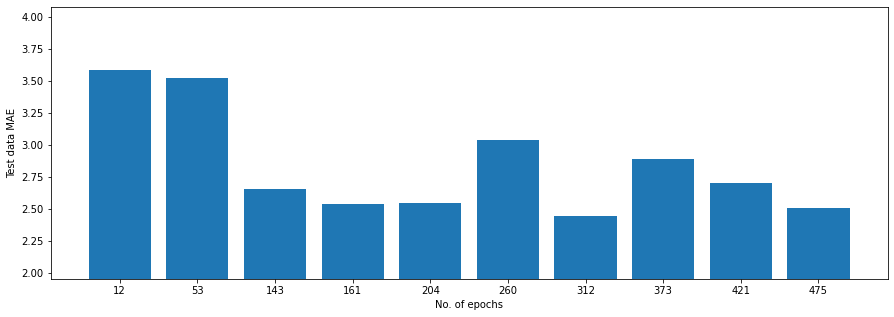

In [235]:
plot_MAE_for_epochs(build_model, [12, 53, 143, 161, 204, 260, 312, 373, 421, 475])

In [244]:
min_MAE_per_interval(model4_avg_mae, 6)

[5,
 10,
 12,
 19,
 24,
 34,
 36,
 45,
 50,
 56,
 62,
 67,
 76,
 81,
 89,
 94,
 97,
 103,
 110,
 116,
 120,
 127,
 137,
 141,
 147,
 153,
 158,
 163,
 173,
 177,
 185,
 186,
 196,
 198,
 205,
 215,
 219,
 223,
 228,
 236,
 243,
 248,
 252,
 259,
 269,
 273,
 277,
 284,
 291,
 295,
 300,
 310,
 314,
 318,
 328,
 333,
 338,
 345,
 349,
 358,
 365,
 371,
 376,
 378,
 388,
 394,
 396,
 405,
 410,
 414,
 421,
 426,
 437,
 443,
 446,
 450,
 459,
 463,
 472,
 475,
 485,
 487,
 493,
 499]

4/4 [==============================] - 1s 3ms/step - loss: 13.8009 - mae: 2.6027


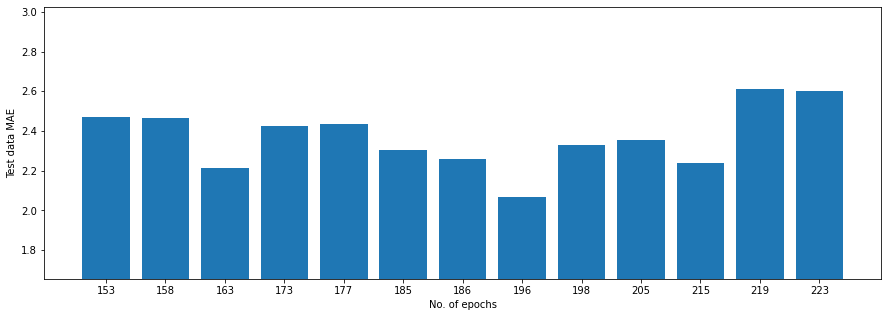

In [245]:
plot_MAE_for_epochs(build_model, [153,158,163,173,177,185,186,196,198,205,215,219,223])

Najlepszy wynik otrzymany do tej pory to MAE na poziomie 2069$ oraz loss równy 10.1239 przy epoce 196.

# Klasyfikacja binarna - wykrywanie nowotworu złośliwego

Dataset: <br>
https://www.kaggle.com/datasets/yasserh/breast-cancer-dataset<br>
https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data

In [14]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import RMSprop

import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Plot training & validation accuracy values: https://keras.io/visualization/#training-history-visualization
plt.rcParams['figure.figsize'] = (15.0, 5.0) # set default size of plots

In [15]:
#get consistent results
from keras.models import Sequential
from keras.layers import Dense
import numpy
from numpy.random import seed
seed(42)

In [16]:
from sklearn.model_selection import train_test_split

In [1]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import RMSprop

import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Plot training & validation accuracy values: https://keras.io/visualization/#training-history-visualization
plt.rcParams['figure.figsize'] = (15.0, 5.0) # set default size of plots

In [2]:
#get consistent results
from keras.models import Sequential
from keras.layers import Dense
import numpy
from numpy.random import seed
seed(42)

## Przygotowywanie danych

In [4]:
# load the data
path = r"/content/breast-cancer.csv"
df = pd.read_csv(path)

In [6]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [5]:
df.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


Kolumny `id` oraz `Unnamed: 32` są zbędne do procesu uczenia, więc zostają usunięte.

In [8]:
df = df.drop(columns=['id'])

In [9]:
df

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


Przewidywana będzie wartość `diagnosis`, więc trzeba zamienić ją na wartości binarne, czyli odpowiednio `0` i `1`.


`B = benign (łagodny)` -> 0 <br>
`M = malignant (złośliwy)` -> 1

W zasadzie można uznać, że przewidujemy czy nowotwór jest złośliwy, jeśli tak to 1, w innym wypadku 0 (łagodny). 

In [10]:
df['diagnosis_binary'] = df['diagnosis'].apply(lambda x: 1 if x == 'M' else 0)
df[['diagnosis', 'diagnosis_binary']]

,diagnosis,diagnosis_binary
0,M,1
1,M,1
2,M,1
3,M,1
4,M,1
...,...,...
564,M,1
565,M,1
566,M,1
567,M,1


Dla lepszego rozumienia co oznaczają dane kolumny zmieniam nazwę z `diagnosis_binary` dla prostszego `is_malignant`. Od tego momentu kolumna `diagnosis` też nie jest już potrzebna, ponieważ informacje w niej zawarte są odzwierciedlone w kolumnie `is_malignant`. 

In [11]:
df = df.drop(columns=['diagnosis'])
df.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis_binary
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


In [12]:
df = df.rename(
    columns = {'diagnosis_binary':'is_malignant'}
)
df

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,is_malignant
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,1
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,1
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,1
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,1


## Skalowanie danych

In [13]:
cols_to_scale = list(df.columns)
# it's not needed to scale the target value so it's removed from the list of columns to scale
cols_to_scale.remove('is_malignant')
print(cols_to_scale)

['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']


In [14]:
normalized_df = df.copy()
# it's not needed to scale the target value
for column in cols_to_scale:
    normalized_df[column] = (df[column] - df[column].mean()) / df[column].std()
normalized_df.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,is_malignant
0,1.096100,-2.071512,1.268817,0.983510,1.567087,3.280628,2.650542,2.530249,2.215566,2.253764,...,-1.358098,2.301575,1.999478,1.306537,2.614365,2.107672,2.294058,2.748204,1.935312,1
1,1.828212,-0.353322,1.684473,1.907030,-0.826235,-0.486643,-0.023825,0.547662,0.001391,-0.867889,...,-0.368879,1.533776,1.888827,-0.375282,-0.430066,-0.146620,1.086129,-0.243675,0.280943,1
2,1.578499,0.455786,1.565126,1.557513,0.941382,1.052000,1.362280,2.035440,0.938859,-0.397658,...,-0.023953,1.346291,1.455004,0.526944,1.081980,0.854222,1.953282,1.151242,0.201214,1
3,-0.768233,0.253509,-0.592166,-0.763792,3.280667,3.399917,1.914213,1.450431,2.864862,4.906602,...,0.133866,-0.249720,-0.549538,3.391291,3.889975,1.987839,2.173873,6.040726,4.930672,1
4,1.748758,-1.150804,1.775011,1.824624,0.280125,0.538866,1.369806,1.427237,-0.009552,-0.561956,...,-1.465481,1.337363,1.219651,0.220362,-0.313119,0.612640,0.728618,-0.867590,-0.396751,1


In [15]:
normalized_df.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,is_malignant
count,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,...,5.690000e+02,5.690000e+02,569.000000,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,569.000000
mean,-1.311195e-16,6.243785e-17,-1.248757e-16,-2.185325e-16,-8.366672e-16,1.998011e-16,3.746271e-17,-4.995028e-17,1.748260e-16,4.838933e-16,...,1.248757e-17,-3.496520e-16,0.000000,-2.122887e-16,-3.621395e-16,8.741299e-17,2.122887e-16,2.622390e-16,-5.744282e-16,0.372583
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.483918
min,-2.027864e+00,-2.227289e+00,-1.982759e+00,-1.453164e+00,-3.109349e+00,-1.608721e+00,-1.113893e+00,-1.260710e+00,-2.741705e+00,-1.818265e+00,...,-2.222039e+00,-1.691872e+00,-1.221348,-2.680337e+00,-1.442609e+00,-1.304683e+00,-1.743529e+00,-2.159060e+00,-1.600431e+00,0.000000
25%,-6.887793e-01,-7.253249e-01,-6.913472e-01,-6.666089e-01,-7.103378e-01,-7.464292e-01,-7.430941e-01,-7.372951e-01,-7.026215e-01,-7.220040e-01,...,-7.479711e-01,-6.889721e-01,-0.641571,-6.906227e-01,-6.804845e-01,-7.558491e-01,-7.557349e-01,-6.412994e-01,-6.913035e-01,0.000000
50%,-2.148925e-01,-1.045442e-01,-2.357726e-01,-2.949274e-01,-3.486040e-02,-2.217454e-01,-3.419391e-01,-3.973715e-01,-7.156354e-02,-1.781226e-01,...,-4.347738e-02,-2.857288e-01,-0.340881,-4.680159e-02,-2.692639e-01,-2.180402e-01,-2.232725e-01,-1.272975e-01,-2.162538e-01,0.000000
75%,4.689800e-01,5.836621e-01,4.992377e-01,3.631877e-01,6.356397e-01,4.934227e-01,5.255994e-01,6.463664e-01,5.303125e-01,4.705693e-01,...,6.577623e-01,5.398040e-01,0.357275,5.970195e-01,5.391944e-01,5.306742e-01,7.118836e-01,4.497425e-01,4.503661e-01,1.000000
max,3.967796e+00,4.647799e+00,3.972634e+00,5.245913e+00,4.766717e+00,4.564409e+00,4.239858e+00,3.924477e+00,4.480808e+00,4.906602e+00,...,3.882489e+00,4.283568e+00,5.924959,3.951897e+00,5.108382e+00,4.696536e+00,2.683516e+00,6.040726e+00,6.840837e+00,1.000000


In [16]:
len(normalized_df.index)

569

## Podział na zbiór treningowy, testowy i walidacyjny

In [71]:
X, y = normalized_df.drop('is_malignant', axis=1), normalized_df['is_malignant']

# set how many records to use
# data_size = len(normalized_df.index)

# In the first step we will split the data in training and remaining dataset
train_data, rem_data, train_targets, rem_targets = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

# split remaining data to test and validation sets
test_size=0.5
val_data, test_data, val_targets, test_targets = train_test_split(rem_data,rem_targets, test_size=test_size, random_state=42) 

## Budowa modelu

In [72]:
def build_model():
  model = models.Sequential()
  model.add(layers.Dense(16, activation='relu',
                          input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(8, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
  model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),   # 'rmsprop'
                loss='binary_crossentropy',
                metrics=['accuracy'])
  print(model.summary())
  return model

In [47]:
model1 = build_model()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 16)                496       
                                                                 
 dense_16 (Dense)            (None, 8)                 136       
                                                                 
 dense_17 (Dense)            (None, 1)                 9         
                                                                 
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________
None


In [48]:
num_epochs = 150
history = model1.fit(train_data, train_targets,
                            validation_data=(val_data, val_targets),
                            epochs=num_epochs, batch_size=16, verbose=0)
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

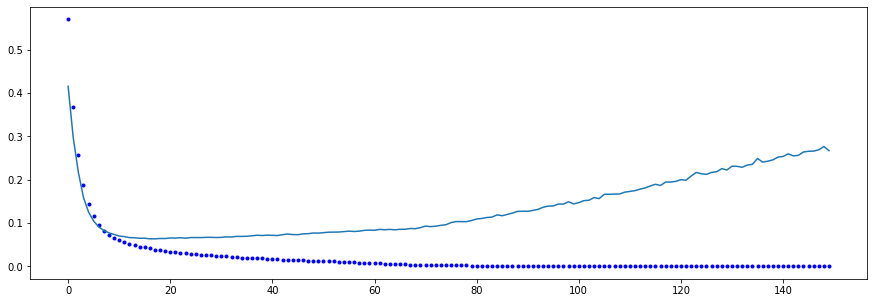

In [49]:
plt.plot(history_dict['loss'], 'b.')
plt.plot(history_dict['val_loss'])

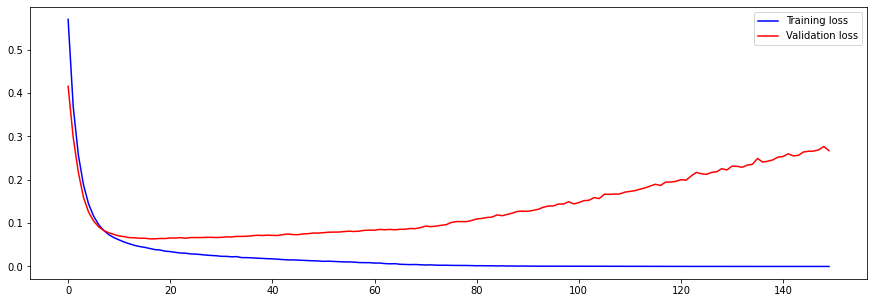

In [50]:
plt.plot(history_dict['loss'], 'b', label='Training loss')
plt.plot(history_dict['val_loss'], 'r', label='Validation loss')
plt.legend(loc='best')

Strata walidacyjna wzrasta podczas gdy strata na zbiorze testowym ciągle maleje. Jest to mocna oznaka overfittingu.


Strata na zbiorze walidacyjnym jest najmniejsza przy ok 18 epoce, można tutaj zastosować Early Stopping, aby zatrzymać uczenie gdy strata na zbiorze walidacyjnym zacznie wzrastać, lecz najpierw ustawię manualnie ilość epok i sprawdzę efekty uczenia.

In [77]:
model1 = build_model()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 16)                496       
                                                                 
 dense_25 (Dense)            (None, 8)                 136       
                                                                 
 dense_26 (Dense)            (None, 1)                 9         
                                                                 
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________
None


In [78]:
num_epochs = 20
history = model1.fit(train_data, train_targets,
                            validation_data=(val_data, val_targets),
                            epochs=num_epochs, batch_size=16, verbose=0)
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

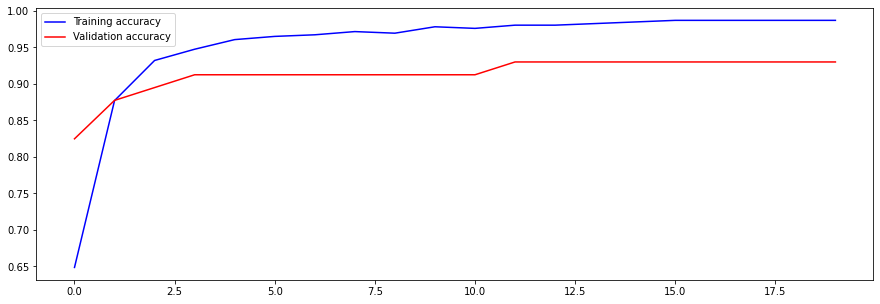

In [79]:
plt.plot(history_dict['accuracy'], 'b', label='Training accuracy')
plt.plot(history_dict['val_accuracy'], 'r', label='Validation accuracy')
plt.legend(loc='best')

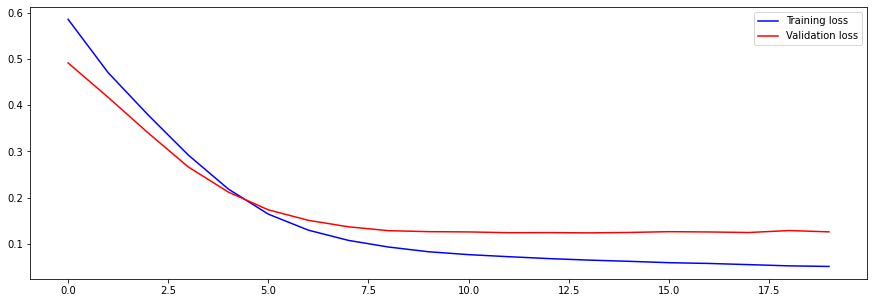

In [80]:
plt.plot(history_dict['loss'], 'b', label='Training loss')
plt.plot(history_dict['val_loss'], 'r', label='Validation loss')
plt.legend(loc='best')

In [81]:
test_loss, test_accuracy = model1.evaluate(test_data, test_targets)
test_accuracy

2/2 [==============================] - 0s 7ms/step - loss: 0.0167 - accuracy: 1.0000


1.0

In [82]:
from sklearn.metrics import confusion_matrix

predicted = model1.predict(test_data)
predicted = list(map(lambda x: x >= 0.5, predicted))
confusion_matrix(test_targets, predicted)

2/2 [==============================] - 0s 5ms/step


array([[41,  0],
       [ 0, 16]])

Dokładność na zbiorze testowym wynosi aż 100% co jest rzadko spotykane. Możliwe, że dane zostały niepoprawnie podzielone przy metodzie `train_test_split()`. Zobaczmy jak wyglądać będą rezultaty, gdy zmniejszymy ilość danych treningowych o 10% na rzecz danych testowych i zbioru walidacyjnego. 

In [83]:
# In the first step we will split the data in training and remaining dataset
train_data, rem_data, train_targets, rem_targets = train_test_split(X, y, train_size=0.7, random_state=42)

# split remaining data to test and validation sets
test_size=0.5
val_data, test_data, val_targets, test_targets = train_test_split(rem_data,rem_targets, test_size=test_size, random_state=42) 

In [110]:
val_data.size

2550

In [112]:
test_data.size

2580

In [113]:
model1 = build_model()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 16)                496       
                                                                 
 dense_43 (Dense)            (None, 8)                 136       
                                                                 
 dense_44 (Dense)            (None, 1)                 9         
                                                                 
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________
None


In [114]:
num_epochs = 60
history = model1.fit(train_data, train_targets,
                            validation_data=(val_data, val_targets),
                            epochs=num_epochs, batch_size=16, verbose=0)
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

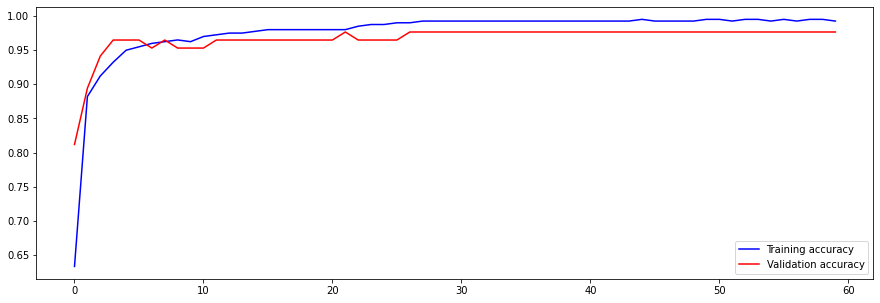

In [115]:
plt.plot(history_dict['accuracy'], 'b', label='Training accuracy')
plt.plot(history_dict['val_accuracy'], 'r', label='Validation accuracy')
plt.legend(loc='best')

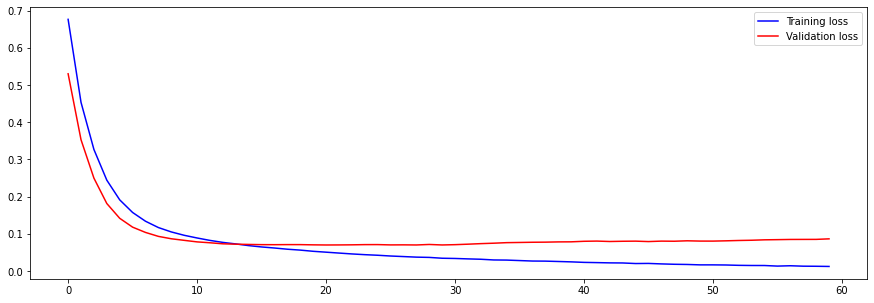

In [116]:
plt.plot(history_dict['loss'], 'b', label='Training loss')
plt.plot(history_dict['val_loss'], 'r', label='Validation loss')
plt.legend(loc='best')

In [117]:
test_loss, test_accuracy = model1.evaluate(test_data, test_targets)
test_accuracy

3/3 [==============================] - 0s 5ms/step - loss: 0.0139 - accuracy: 0.9884


0.9883720874786377

Tak jak wcześniej wspominałem teraz ustawiony zostanie Early Stopping, który zatrzyma proces uczenia gdy nie będzie widać oznak poprawy.

In [121]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [119]:
model1 = build_model()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 16)                496       
                                                                 
 dense_46 (Dense)            (None, 8)                 136       
                                                                 
 dense_47 (Dense)            (None, 1)                 9         
                                                                 
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________
None


In [122]:
num_epochs = 60
history = model1.fit(train_data, train_targets,
                      validation_data=(val_data, val_targets),
                      epochs=num_epochs, batch_size=16, verbose=0,
                      callbacks=[early_stopping])
history_dict = history.history
history_dict.keys()

Epoch 21: early stopping


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

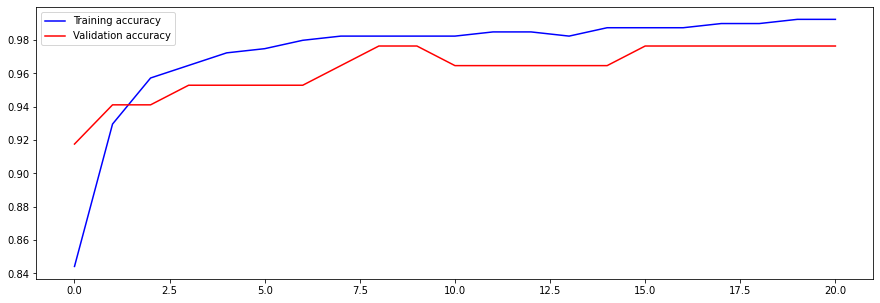

In [123]:
plt.plot(history_dict['accuracy'], 'b', label='Training accuracy')
plt.plot(history_dict['val_accuracy'], 'r', label='Validation accuracy')
plt.legend(loc='best')

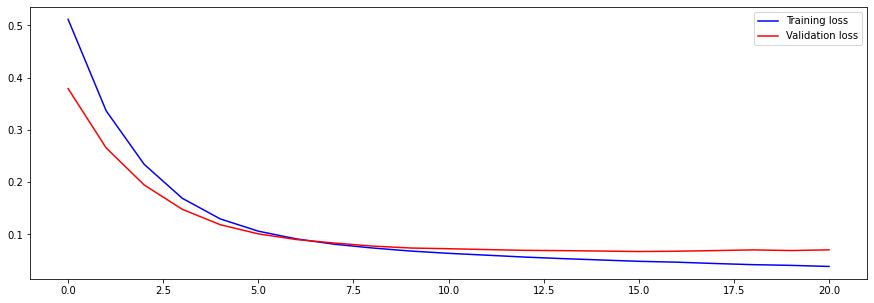

In [124]:
plt.plot(history_dict['loss'], 'b', label='Training loss')
plt.plot(history_dict['val_loss'], 'r', label='Validation loss')
plt.legend(loc='best')

In [125]:
test_loss, test_accuracy = model1.evaluate(test_data, test_targets)
test_accuracy

3/3 [==============================] - 0s 4ms/step - loss: 0.0175 - accuracy: 1.0000


1.0

Użycie Early Stopping poprawiło wydajność modelu. Dokładność na zbiorze testowym jest zaskakująco duża.

# Regresja - predykcja ceny diamentów

Dataset: https://www.kaggle.com/datasets/nancyalaswad90/diamonds-prices

### Przygotowywanie danych

In [5]:
# load the dataset
df = pd.read_csv(r"/content/diamond_prices.csv")

In [ ]:
df

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...,...
53938,53939,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74
53939,53940,0.75,Ideal,D,SI2,62.2,55.0,2757,5.83,5.87,3.64
53940,53941,0.71,Premium,E,SI1,60.5,55.0,2756,5.79,5.74,3.49
53941,53942,0.71,Premium,F,SI1,59.8,62.0,2756,5.74,5.73,3.43


In [6]:
# remove redundant index column
df = df.drop(columns=['Unnamed: 0'], inplace=False)

In [ ]:
df['cut'].value_counts()

Ideal        21551
Premium      13793
Very Good    12083
Good          4906
Fair          1610
Name: cut, dtype: int64

In [ ]:
df['color'].value_counts()

G    11292
E     9799
F     9543
H     8304
D     6775
I     5422
J     2808
Name: color, dtype: int64

In [ ]:
df['clarity'].value_counts()

SI1     13067
VS2     12259
SI2      9194
VS1      8171
VVS2     5066
VVS1     3655
IF       1790
I1        741
Name: clarity, dtype: int64

Wartości kolumn `cut`, `color`, `clarity` są typu `string`, więc aby przygotować je do uczenia trzeba zastosować one-hot encoding.

In [7]:
cut_one_hot = pd.get_dummies(df.cut, prefix='cut')
df_prepared = pd.concat([df, cut_one_hot], axis=1)

In [ ]:
df_prepared

,carat,cut,color,clarity,depth,table,price,x,y,z,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very Good
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,0,0,1,0,0
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,0,0,0,1,0
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,0,1,0,0,0
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63,0,0,0,1,0
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74,0,0,0,1,0
53939,0.75,Ideal,D,SI2,62.2,55.0,2757,5.83,5.87,3.64,0,0,1,0,0
53940,0.71,Premium,E,SI1,60.5,55.0,2756,5.79,5.74,3.49,0,0,0,1,0
53941,0.71,Premium,F,SI1,59.8,62.0,2756,5.74,5.73,3.43,0,0,0,1,0


In [8]:
color_one_hot = pd.get_dummies(df.cut, prefix='color')
clarity_one_hot = pd.get_dummies(df.clarity, prefix='clarity')
df_prepared = pd.concat([df_prepared, color_one_hot, clarity_one_hot], axis=1)

In [ ]:
df_prepared.head()

,carat,cut,color,clarity,depth,table,price,x,y,z,...,color_Premium,color_Very Good,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,...,0,0,0,0,0,1,0,0,0,0
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,...,1,0,0,0,1,0,0,0,0,0
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,...,0,0,0,0,0,0,1,0,0,0
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63,...,1,0,0,0,0,0,0,1,0,0
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
df_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53943 entries, 0 to 53942
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   carat            53943 non-null  float64
 1   cut              53943 non-null  object 
 2   color            53943 non-null  object 
 3   clarity          53943 non-null  object 
 4   depth            53943 non-null  float64
 5   table            53943 non-null  float64
 6   price            53943 non-null  int64  
 7   x                53943 non-null  float64
 8   y                53943 non-null  float64
 9   z                53943 non-null  float64
 10  cut_Fair         53943 non-null  uint8  
 11  cut_Good         53943 non-null  uint8  
 12  cut_Ideal        53943 non-null  uint8  
 13  cut_Premium      53943 non-null  uint8  
 14  cut_Very Good    53943 non-null  uint8  
 15  color_Fair       53943 non-null  uint8  
 16  color_Good       53943 non-null  uint8  
 17  color_Ideal 

In [9]:
# Drop column replaced with one-hot encoding
df_prepared = df_prepared.drop(columns=['cut', 'color', 'clarity'])

In [ ]:
df_prepared.head()

,carat,depth,table,price,x,y,z,cut_Fair,cut_Good,cut_Ideal,...,color_Premium,color_Very Good,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0,0,0,...,1,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,327,4.05,4.07,2.31,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,335,4.34,4.35,2.75,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
df_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53943 entries, 0 to 53942
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   carat            53943 non-null  float64
 1   depth            53943 non-null  float64
 2   table            53943 non-null  float64
 3   price            53943 non-null  int64  
 4   x                53943 non-null  float64
 5   y                53943 non-null  float64
 6   z                53943 non-null  float64
 7   cut_Fair         53943 non-null  uint8  
 8   cut_Good         53943 non-null  uint8  
 9   cut_Ideal        53943 non-null  uint8  
 10  cut_Premium      53943 non-null  uint8  
 11  cut_Very Good    53943 non-null  uint8  
 12  color_Fair       53943 non-null  uint8  
 13  color_Good       53943 non-null  uint8  
 14  color_Ideal      53943 non-null  uint8  
 15  color_Premium    53943 non-null  uint8  
 16  color_Very Good  53943 non-null  uint8  
 17  clarity_I1  

#### Skalowanie danych

In [10]:
cols_to_scale = list(df_prepared.columns)
# it's not needed to scale the target value so it's removed from columns to scale
cols_to_scale.remove('price')
print(cols_to_scale)

['carat', 'depth', 'table', 'x', 'y', 'z', 'cut_Fair', 'cut_Good', 'cut_Ideal', 'cut_Premium', 'cut_Very Good', 'color_Fair', 'color_Good', 'color_Ideal', 'color_Premium', 'color_Very Good', 'clarity_I1', 'clarity_IF', 'clarity_SI1', 'clarity_SI2', 'clarity_VS1', 'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2']


In [11]:
normalized_df = df_prepared.copy()
# it's not needed to scale the target value
for column in cols_to_scale:
    normalized_df[column] = (df_prepared[column] - df_prepared[column].mean())/df_prepared[column].std()
normalized_df.head()

,carat,depth,table,price,x,y,z,cut_Fair,cut_Good,cut_Ideal,...,color_Premium,color_Very Good,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,-1.198178,-0.174032,-1.099663,326,-1.587868,-1.536224,-1.571152,-0.175397,-0.316299,1.225974,...,-0.586115,-0.537259,-0.118016,-0.185261,-0.565392,2.206152,-0.422507,-0.542299,-0.269592,-0.321941
1,-1.240372,-1.360664,1.585442,326,-1.641356,-1.658805,-1.741201,-0.175397,-0.316299,-0.815663,...,1.706119,-0.537259,-0.118016,-0.185261,1.768651,-0.453270,-0.422507,-0.542299,-0.269592,-0.321941
2,-1.198178,-3.384918,3.375513,327,-1.498720,-1.457422,-1.741201,-0.175397,3.161507,-0.815663,...,-0.586115,-0.537259,-0.118016,-0.185261,-0.565392,-0.453270,2.366782,-0.542299,-0.269592,-0.321941
3,-1.071595,0.454185,0.242890,334,-1.364997,-1.317330,-1.287737,-0.175397,-0.316299,-0.815663,...,1.706119,-0.537259,-0.118016,-0.185261,-0.565392,-0.453270,-0.422507,1.843967,-0.269592,-0.321941
4,-1.029401,1.082402,0.242890,335,-1.240190,-1.212261,-1.117688,-0.175397,3.161507,-0.815663,...,-0.586115,-0.537259,-0.118016,-0.185261,-0.565392,2.206152,-0.422507,-0.542299,-0.269592,-0.321941


In [12]:
normalized_df.describe()

,carat,depth,table,price,x,y,z,cut_Fair,cut_Good,cut_Ideal,...,color_Premium,color_Very Good,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
count,5.394300e+04,5.394300e+04,5.394300e+04,53943.000000,5.394300e+04,5.394300e+04,5.394300e+04,5.394300e+04,5.394300e+04,5.394300e+04,...,5.394300e+04,5.394300e+04,5.394300e+04,5.394300e+04,5.394300e+04,5.394300e+04,5.394300e+04,5.394300e+04,5.394300e+04,5.394300e+04
mean,1.896783e-16,-3.690757e-15,-5.648198e-16,3932.734294,-7.376378e-17,2.971626e-16,-3.350983e-16,-3.161305e-17,1.106457e-16,1.433125e-16,...,-1.475276e-16,-1.264522e-17,3.372058e-17,-4.162384e-17,2.529044e-17,3.319370e-17,1.580652e-17,2.739797e-17,-1.053768e-17,-9.378537e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,3989.338447,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.261469e+00,-1.308738e+01,-6.469874e+00,326.000000,-5.109215e+00,-5.021024e+00,-5.014642e+00,-1.753966e-01,-3.162990e-01,-8.156631e-01,...,-5.861146e-01,-5.372591e-01,-1.180161e-01,-1.852605e-01,-5.653921e-01,-4.532696e-01,-4.225067e-01,-5.422990e-01,-2.695923e-01,-3.219410e-01
25%,-8.395272e-01,-5.230411e-01,-6.521456e-01,950.000000,-9.103425e-01,-8.882969e-01,-8.909563e-01,-1.753966e-01,-3.162990e-01,-8.156631e-01,...,-5.861146e-01,-5.372591e-01,-1.180161e-01,-1.852605e-01,-5.653921e-01,-4.532696e-01,-4.225067e-01,-5.422990e-01,-2.695923e-01,-3.219410e-01
50%,-2.066139e-01,3.537389e-02,-2.046280e-01,2401.000000,-2.777681e-02,-2.147481e-02,-1.237047e-02,-1.753966e-01,-3.162990e-01,-8.156631e-01,...,-5.861146e-01,-5.372591e-01,-1.180161e-01,-1.852605e-01,-5.653921e-01,-4.532696e-01,-4.225067e-01,-5.422990e-01,-2.695923e-01,-3.219410e-01
75%,5.106879e-01,5.239870e-01,6.904073e-01,5324.000000,7.210668e-01,7.052548e-01,7.103372e-01,-1.753966e-01,-3.162990e-01,1.225974e+00,...,1.706119e+00,-5.372591e-01,-1.180161e-01,-1.852605e-01,-5.653921e-01,-4.532696e-01,-4.225067e-01,-5.422990e-01,-2.695923e-01,-3.219410e-01
max,8.886241e+00,1.204130e+01,1.680104e+01,18823.000000,4.465285e+00,4.655051e+01,4.004831e+01,5.701260e+00,3.161507e+00,1.225974e+00,...,1.706119e+00,1.861265e+00,8.473266e+00,5.397705e+00,1.768651e+00,2.206152e+00,2.366782e+00,1.843967e+00,3.709236e+00,3.106102e+00


#### Wyznaczanie zbioru testowego i treningowego

In [13]:
X, y = normalized_df.drop('price', axis=1), normalized_df['price']

# train_data, train_targets, test_data, test_targets = train_test_split(X, y, random_state=42)
# set how many rows to use 
data_size = 10000

# In the first step we will split the data in training and remaining dataset
train_data, rem_data, train_targets, rem_targets = train_test_split(X[:10000],y[:10000], train_size=0.8, random_state=42)
test_size=0.5
# split remaining data to test and validation sets
val_data, test_data, val_targets, test_targets = train_test_split(rem_data,rem_targets, test_size=test_size, random_state=42)

### Budowanie sieci

In [ ]:
def build_model():
    # Because we will need to instantiate the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(32, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [ ]:
model = build_model()
num_epochs = 150
history = model.fit(train_data, train_targets,
                            validation_data=(val_data, val_targets),
                            epochs=num_epochs, batch_size=16, verbose=0)

In [ ]:
def plot_model_mae(mae_history, argmin=0):
    # smooth_mae_history = smooth_curve(average_mae_history[10:])
    # omit 10 becuase of different value scale 
    smooth_mae_history = mae_history[10:]
    plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
    plt.axvline(x=argmin, color='r', linewidth=2)
    plt.xlabel('Epochs')
    plt.ylabel('Validation MAE')
    plt.show()

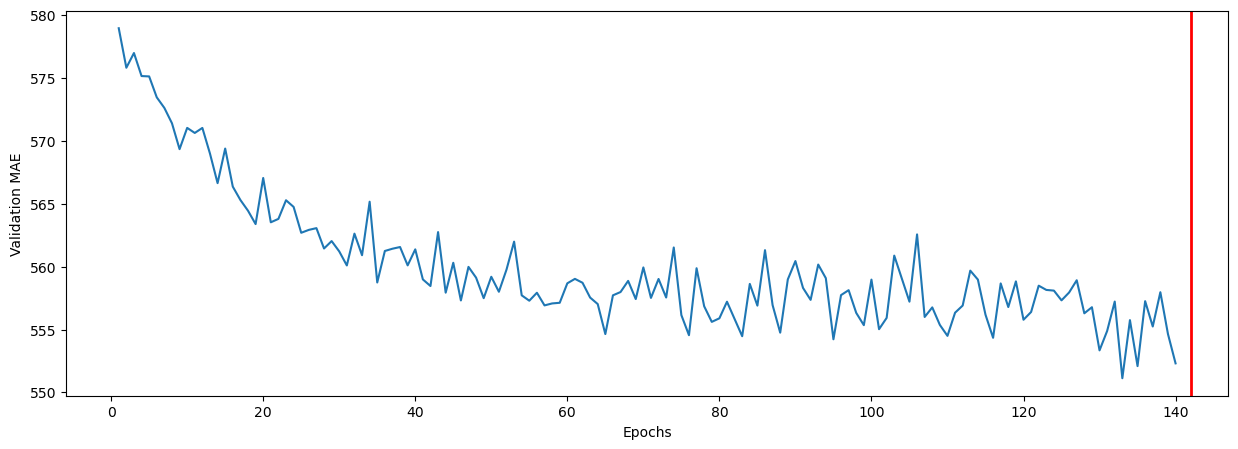

In [ ]:
mae_history = history.history['val_mae']

plot_model_mae(mae_history, np.argmin(mae_history))

In [ ]:
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

169/169 [==============================] - 1s 4ms/step - loss: 917091.1875 - mae: 526.6548


526.6548461914062

<AxesSubplot:ylabel='Frequency'>

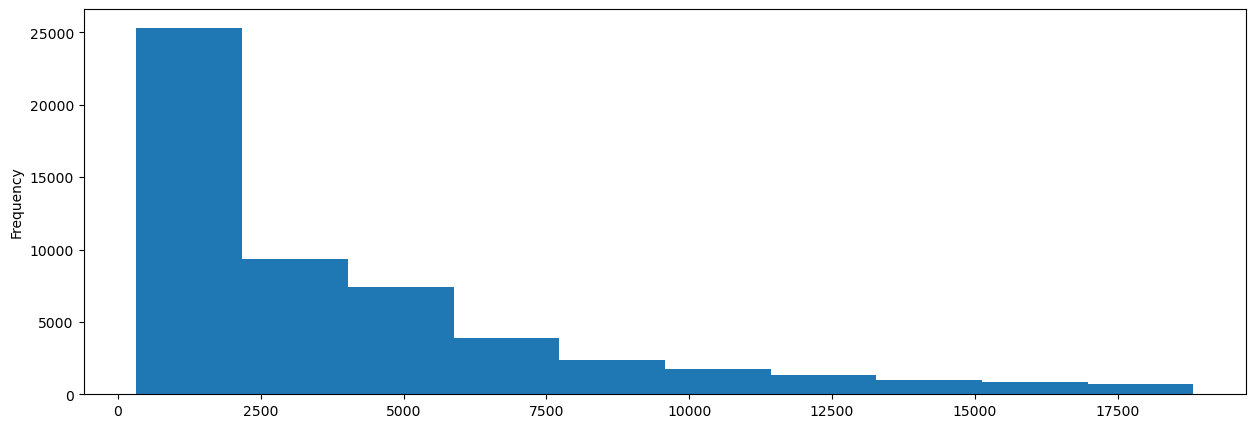

In [ ]:
df.price.plot.hist()

Loss w tym przypadku jest ogromny, chociaż MAE jest na akceptowalnym poziomie. Uczenie trwało dość długo czasu więc lepiej w tym wypadku ograniczyć nieco zbiór wykorzystywany do uczenia.  

### Zmniejszenie ilości danych i kolejne podejście do uczenia

In [ ]:
# set how many rows to use 
data_size = 10000

# In the first step we will split the data in training and remaining dataset
train_data, rem_data, train_targets, rem_targets = train_test_split(X[:10000],y[:10000], train_size=0.8, random_state=42)

# split remaining data to test and validation sets
test_size=0.5
val_data, test_data, val_targets, test_targets = train_test_split(rem_data,rem_targets, test_size=test_size, random_state=42) 

In [ ]:
num_epochs = 50

model = build_model()
history = model.fit(train_data, train_targets,
                            validation_data=(val_data, val_targets),
                            epochs=num_epochs, batch_size=16, verbose=0)

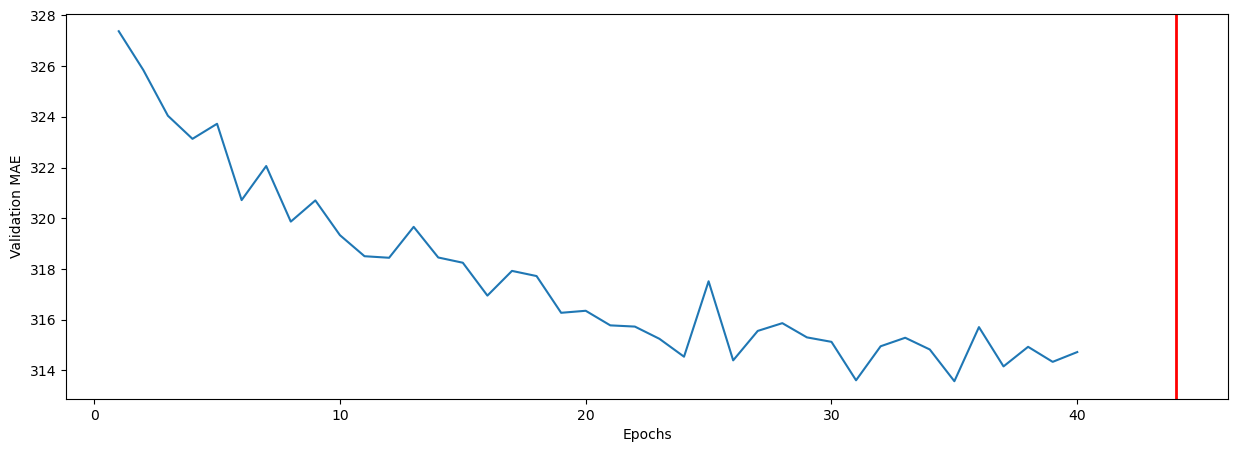

In [ ]:
mae_history = history.history['val_mae']

plot_model_mae(mae_history, np.argmin(mae_history))

In [ ]:
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

32/32 [==============================] - 0s 4ms/step - loss: 139461.5781 - mae: 293.6982


293.6981506347656

#### Po zmniejszeniu wyniki okazały się o wiele lepsze, chociaż los nadal jest bardzo duży. Niestety okazuje się, że pierwsze 10 000 rekordów nie są zbiorem reprezentacyjnym (wizualizacja poniżej).

<AxesSubplot:ylabel='Frequency'>

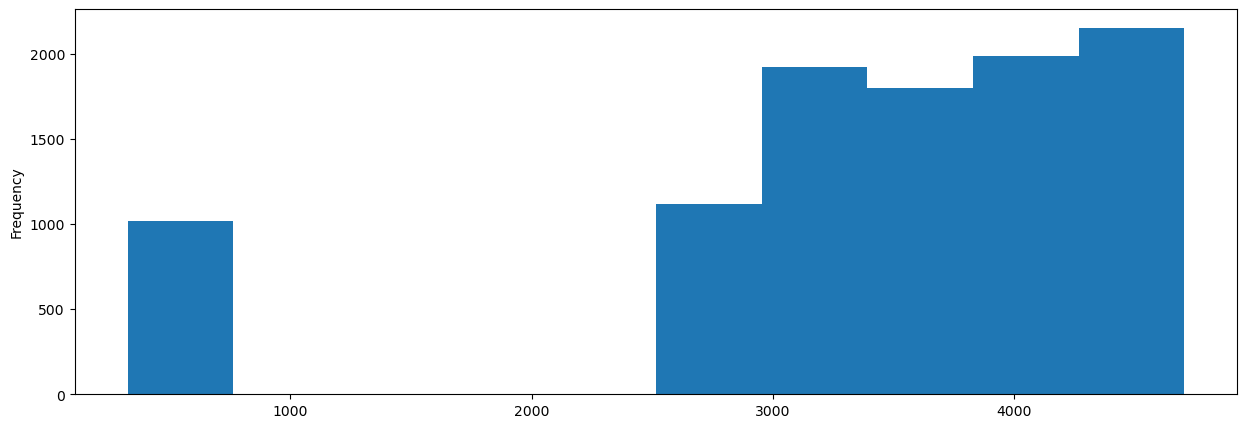

In [ ]:
df.price[:10000].plot.hist()

<AxesSubplot:ylabel='Frequency'>

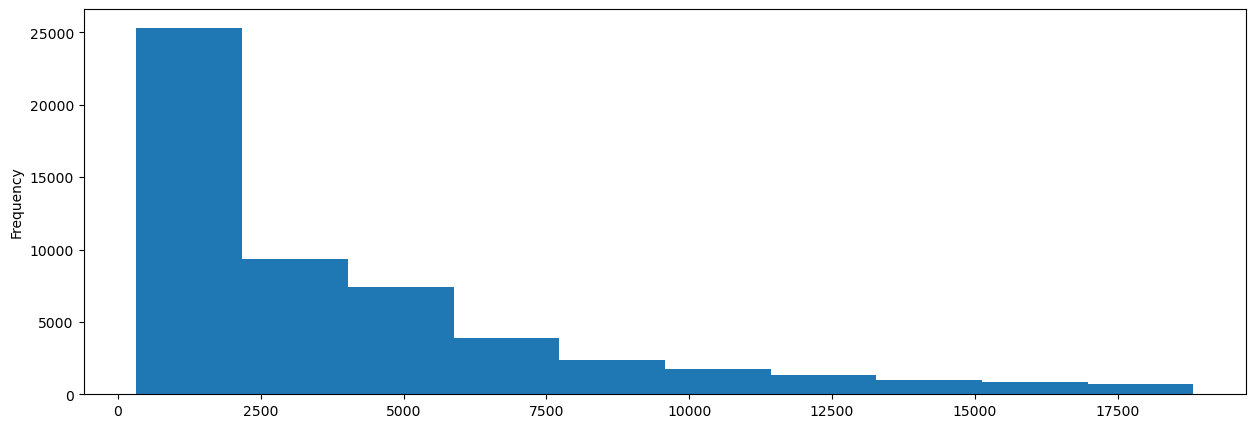

In [ ]:
df.price.plot.hist()

In [ ]:
# set how many rows to use as fraction 
data_size = 10000 / len(df.index)

# In the first step we will split the data in training and remaining dataset
train_data, rem_data, train_targets, rem_targets = train_test_split(X, y, train_size=0.8*data_size, test_size=0.2*data_size, random_state=42)

# split remaining data to test and validation sets
test_size=0.5
val_data, test_data, val_targets, test_targets = train_test_split(rem_data,rem_targets, test_size=test_size, random_state=42) 

<AxesSubplot:ylabel='Frequency'>

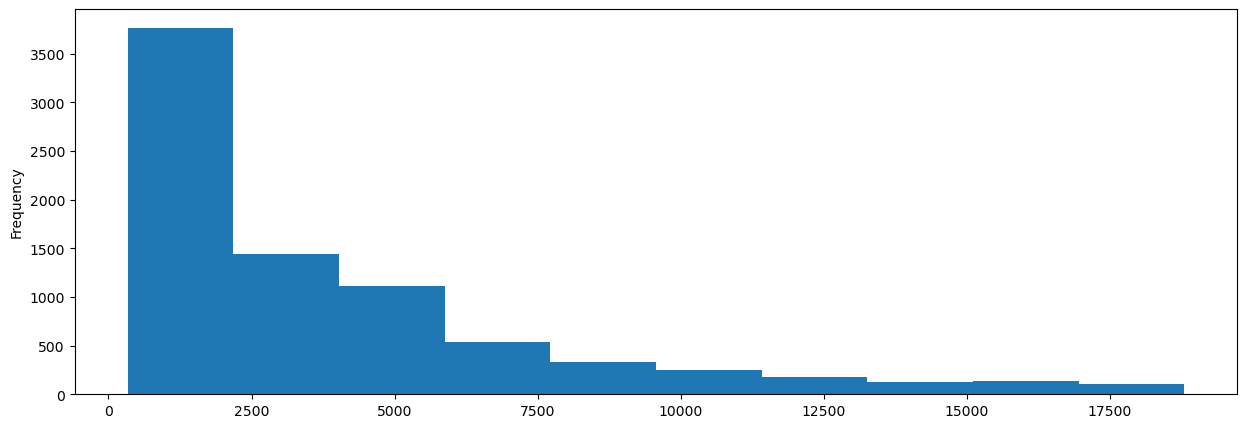

In [ ]:
train_targets.plot.hist()

#### Teraz dane treningowe i testowe posiadają o wiele bardziej zbliżony rozkład do pierwotnego zbioru.

In [ ]:
num_epochs = 300

model = build_model()
history = model.fit(train_data, train_targets,
                            validation_data=(val_data, val_targets),
                            epochs=num_epochs, batch_size=16, verbose=0)

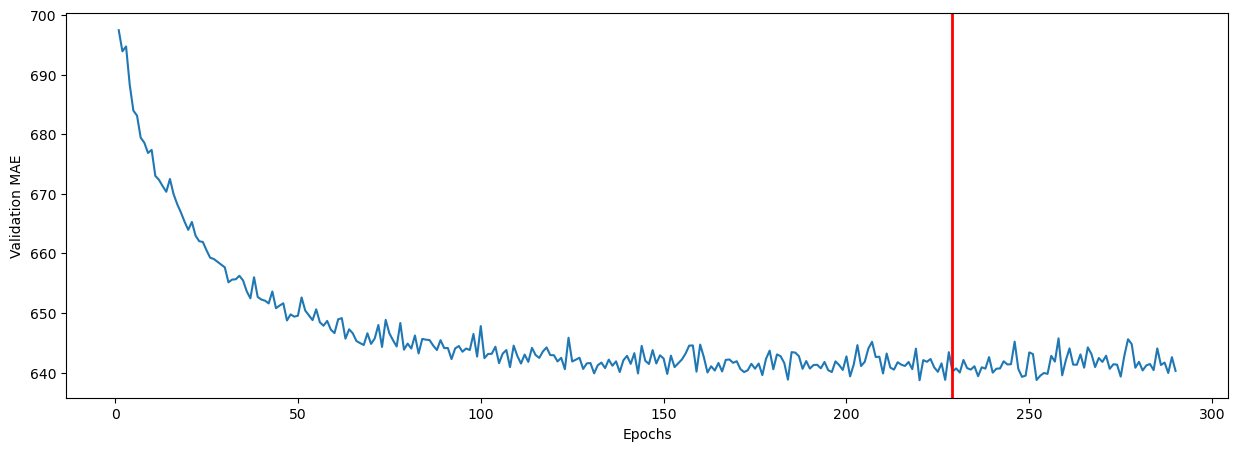

In [ ]:
mae_history = history.history['val_mae']

plot_model_mae(mae_history, np.argmin(mae_history))

In [ ]:
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

32/32 [==============================] - 0s 4ms/step - loss: 1063426.5000 - mae: 581.4421


581.4420776367188

### MAE wygląda wiarygodnie, niestety nadal występuje duży loss. Pora zmienić architekturę sieci.

In [ ]:
def build_model():
    # Because we will need to instantiate the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(256, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(192, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [ ]:
model = build_model()
num_epochs = 500
history = model.fit(train_data, train_targets,
                            validation_data=(val_data, val_targets),
                            epochs=num_epochs, batch_size=32, verbose=0)

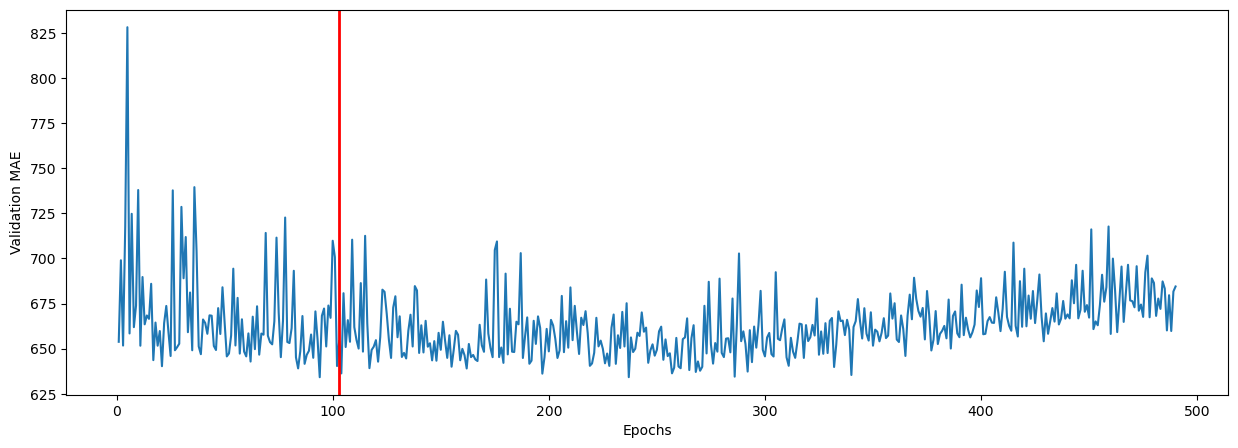

In [ ]:
mae_history = history.history['val_mae']

plot_model_mae(mae_history, np.argmin(mae_history))

In [ ]:
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

32/32 [==============================] - 0s 4ms/step - loss: 1736983.7500 - mae: 680.0534


680.0534057617188

### Funkcja straty to MAE^2 (MSE) dlatego osiąga tak duże wartości. Na ten moment nejlepsze wyniki dostarczył model pierwszy, lecz na pewno jest jeszcze miejsce na jego poprawę. 

In [18]:
def build_model():
    # Because we will need to instantiate the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(256, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(192, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [19]:
model = build_model()
num_epochs = 200
history = model.fit(train_data, train_targets,
                            validation_data=(val_data, val_targets),
                            epochs=num_epochs, batch_size=32, verbose=0)

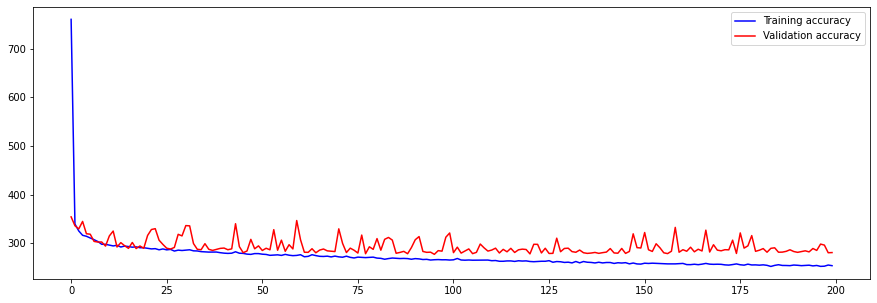

In [20]:
history_dict = history.history
print(history_dict.keys())
plt.plot(history_dict['mae'], 'b', label='Training MAE')
plt.plot(history_dict['val_mae'], 'r', label='Validation MAE')
plt.legend(loc='best')

In [21]:
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

32/32 [==============================] - 0s 2ms/step - loss: 128299.7891 - mae: 262.1038


262.10382080078125

Ten sam model co poprzednio uczony przez 200 epok sprawuje się o wiele lepiej. MAE zmalało o około 60%, a loss z ponad 1.5 mln spadł do 128 tysięcy.  

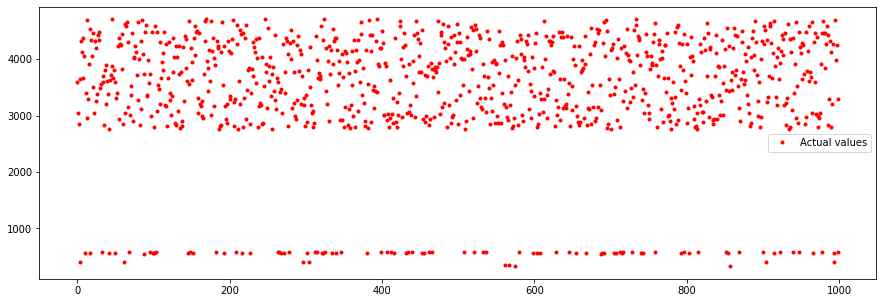

In [33]:
X = np.array(range(len(test_data)))

plt.plot(X, test_targets,'r.', label='Actual values')
plt.legend(loc='best')

32/32 [==============================] - 0s 1ms/step


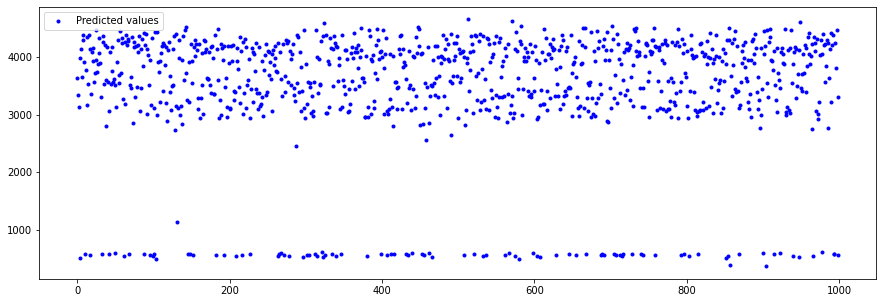

In [34]:
predicted_data = model.predict(test_data)
plt.plot(X, predicted_data,'b.', label='Predicted values')
plt.legend(loc='best')

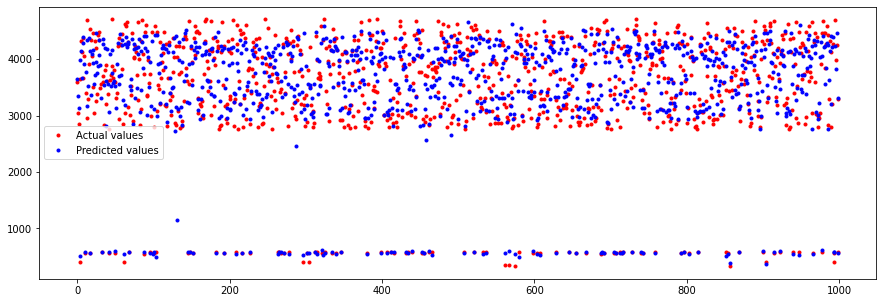

In [29]:
plt.plot(X, test_targets,'r.', label='Actual values')
plt.plot(X, predicted_data,'b.', label='Predicted values')
plt.legend(loc='best')

Jak widać otrzymane z predykcji wyniki stanowiące cenę diamentów zdają się być całkiem dobrze dopasowane. Pojawiły się też outliery.

Sprawdźmy czy po dodaniu callbacka Early Stopping wynik jeszcze bardziej się poprawi.

In [35]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [36]:
model = build_model()
num_epochs = 200
history = model.fit(train_data, train_targets,
                            validation_data=(val_data, val_targets),
                            epochs=num_epochs, batch_size=32, verbose=0,
                            callbacks=[early_stopping])

Epoch 18: early stopping


dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


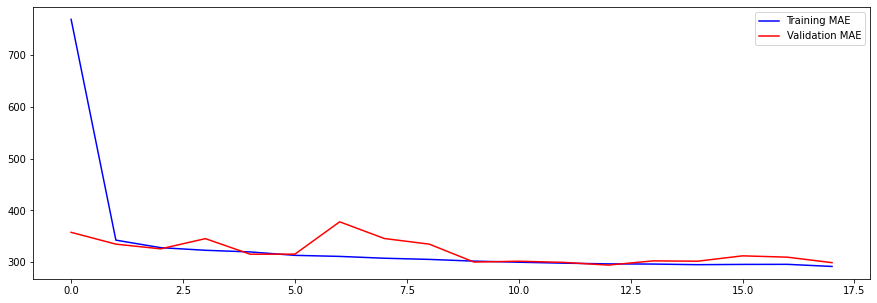

In [37]:
history_dict = history.history
print(history_dict.keys())
plt.plot(history_dict['mae'], 'b', label='Training MAE')
plt.plot(history_dict['val_mae'], 'r', label='Validation MAE')
plt.legend(loc='best')

In [38]:
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

32/32 [==============================] - 0s 2ms/step - loss: 134868.7031 - mae: 276.5580


276.5580139160156

W tym przypadku wynik się pogorszył. Sprawdźmy co przyniesie zwiększenie paramteru `patience` w Early Stopping.

In [49]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=35)

model = build_model()
num_epochs = 200
history = model.fit(train_data, train_targets,
                            validation_data=(val_data, val_targets),
                            epochs=num_epochs, batch_size=32, verbose=0,
                            callbacks=[early_stopping])

Epoch 65: early stopping


dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


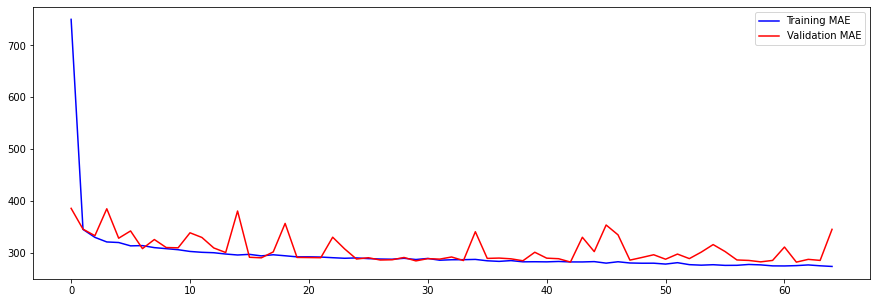

In [50]:
history_dict = history.history
print(history_dict.keys())
plt.plot(history_dict['mae'], 'b', label='Training MAE')
plt.plot(history_dict['val_mae'], 'r', label='Validation MAE')
plt.legend(loc='best')

In [51]:
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

32/32 [==============================] - 0s 2ms/step - loss: 191869.2031 - mae: 328.3545


328.3544616699219

Tym razem callback Early Stopping nie przyniósł lepszych rezultatów od modelu uczonego poprzez ręczne wyznaczenie liczby epok.

# Klasyfikacja wieloklasowa - predykcja klasy sprawności fizycznej

Dataset: <br>
https://www.kaggle.com/datasets/kukuroo3/body-performance-data

Na podstawie datasetu przewidywana będzie klasa sprawności człowieka na podstawie danych o sprawności fizycznej oraz stanie ciała człowieka. Są 4 klasy sprawności:
```
class : A,B,C,D ( A: best) 

```

In [3]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import RMSprop

import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Plot training & validation accuracy values: https://keras.io/visualization/#training-history-visualization
plt.rcParams['figure.figsize'] = (15.0, 5.0) # set default size of plots

In [4]:
#get consistent results
from keras.models import Sequential
from keras.layers import Dense
import numpy
from numpy.random import seed
seed(42)

In [5]:
# declare lists for accuracy and loss for further visualisations
all_accs = []
all_val_accs = []
all_losses = []
all_val_losses = []

## Przygotowywanie danych

In [10]:
# load the data
path = r"/content/bodyPerformance.csv"
df = pd.read_csv(path)

In [11]:
df.head()

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
3,32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
4,28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B


In [12]:
df.describe()

,age,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm
count,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000
mean,36.775106,168.559807,67.447316,23.240165,78.796842,130.234817,36.963877,15.209268,39.771224,190.129627
std,13.625639,8.426583,11.949666,7.256844,10.742033,14.713954,10.624864,8.456677,14.276698,39.868000
min,21.000000,125.000000,26.300000,3.000000,0.000000,0.000000,0.000000,-25.000000,0.000000,0.000000
25%,25.000000,162.400000,58.200000,18.000000,71.000000,120.000000,27.500000,10.900000,30.000000,162.000000
50%,32.000000,169.200000,67.400000,22.800000,79.000000,130.000000,37.900000,16.200000,41.000000,193.000000
75%,48.000000,174.800000,75.300000,28.000000,86.000000,141.000000,45.200000,20.700000,50.000000,221.000000
max,64.000000,193.800000,138.100000,78.400000,156.200000,201.000000,70.500000,213.000000,80.000000,303.000000


Aby dane nadawały się do nauki sieci trzeba wykonać one-hot encoding na wartościach `gender` oraz `class`

In [13]:
prepared_df = df.join(pd.get_dummies(df['gender'], prefix='gender'))
prepared_df.drop(columns=['gender'], inplace=True)
prepared_df = prepared_df.join(pd.get_dummies(df['class'], prefix='class'))
prepared_df.drop(columns=['class'], inplace=True)
prepared_df.head()

,age,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,gender_F,gender_M,class_A,class_B,class_C,class_D
0,27.0,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,0,1,0,0,1,0
1,25.0,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,0,1,1,0,0,0
2,31.0,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,0,1,0,0,1,0
3,32.0,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,0,1,0,1,0,0
4,28.0,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,0,1,0,1,0,0


### Skalowanie danych

In [14]:
cols_to_scale = list(prepared_df.columns[:-4])
# it's not needed to scale the target value so it's removed from the list of columns to scale
print(cols_to_scale)

['age', 'height_cm', 'weight_kg', 'body fat_%', 'diastolic', 'systolic', 'gripForce', 'sit and bend forward_cm', 'sit-ups counts', 'broad jump_cm', 'gender_F', 'gender_M']


In [15]:
normalized_df = prepared_df.copy()
# it's not needed to scale the target value
for column in cols_to_scale:
    normalized_df[column] = (prepared_df[column] - prepared_df[column].mean()) / prepared_df[column].std()
normalized_df.head()

,age,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,gender_F,gender_M,class_A,class_B,class_C,class_D
0,-0.717405,0.443856,0.652126,-0.267357,0.112005,-0.015959,1.688127,0.377303,1.416909,0.673983,-0.762722,0.762722,0,0,1,0
1,-0.864187,-0.422450,-0.974698,-1.039042,-0.167272,-0.287810,-0.053071,0.128979,0.926599,0.974977,-0.762722,0.762722,1,0,0,0
2,-0.423841,1.310163,0.883094,-0.432718,1.229112,1.479221,0.737527,-0.379495,0.646422,-0.228996,-0.762722,0.762722,0,0,1,0
3,-0.350450,0.704935,0.305672,-0.666979,-0.260364,1.139407,0.417523,-0.001096,0.926599,0.724149,-0.762722,0.762722,0,1,0,0
4,-0.644014,0.621865,0.021146,-0.846121,-0.818918,-0.219847,0.615172,1.406076,0.366245,0.673983,-0.762722,0.762722,0,1,0,0


## Przygotowanie zbioru treningowego, walidacyjnego, testowego 

In [16]:
X, y = normalized_df.drop(normalized_df.filter(regex='class').columns, axis=1), normalized_df[normalized_df.filter(regex='class').columns]

# set how many records to use
# data_size = len(normalized_df.index)

# In the first step we will split the data in training and remaining dataset
train_data, rem_data, train_targets, rem_targets = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

# split remaining data to test and validation sets
test_size=0.5
val_data, test_data, val_targets, test_targets = train_test_split(rem_data,rem_targets, test_size=test_size, random_state=42) 

In [ ]:
train_data

,age,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,gender_F,gender_M
8045,-0.717405,0.621865,1.636254,0.118486,1.508388,1.886997,0.276344,0.862127,0.716467,-0.028334,-0.762722,0.762722
12964,-1.084361,-0.932740,-1.811541,0.022025,0.018912,-0.355772,-1.238969,2.009150,-0.334197,-1.182142,1.310996,-1.310996
12642,0.897198,-2.214398,-0.489329,2.405982,1.508388,-0.083921,-1.342500,0.471903,-2.225390,-1.056728,1.310996,-1.310996
9002,-0.056886,1.310163,1.142516,-1.011482,0.112005,0.052004,1.339888,-0.994394,0.436290,0.648901,-0.762722,0.762722
12596,-0.497232,0.004770,0.183493,-0.184676,1.880757,0.459780,0.633996,0.672928,1.346864,1.301053,-0.762722,0.762722
...,...,...,...,...,...,...,...,...,...,...,...,...
11964,-1.010970,1.274561,1.242937,-0.157116,0.949835,0.595706,1.085767,0.412778,0.926599,1.677294,-0.762722,0.762722
5191,-0.203668,0.277716,-0.171328,-0.666979,-1.563656,-1.103362,-0.438959,-1.431918,0.296201,0.899728,-0.762722,0.762722
5390,-0.717405,-0.007097,-1.506930,-1.011482,-0.818918,-0.967437,-1.107203,0.732053,0.506334,-0.203914,1.310996,-1.310996
860,-1.157752,0.111575,1.360095,2.709144,-0.539641,0.527743,-1.446030,0.601978,0.226157,-0.605238,1.310996,-1.310996


In [ ]:
train_targets

,class_A,class_B,class_C,class_D
8045,0,0,0,1
12964,0,1,0,0
12642,0,0,0,1
9002,0,0,1,0
12596,1,0,0,0
...,...,...,...,...
11964,0,1,0,0
5191,0,0,0,1
5390,1,0,0,0
860,0,0,0,1


In [ ]:
print(len(train_data), len(val_data), len(test_data))

10714 1339 1340


## Budowa sieci neuronowej


In [17]:
no_classes = 4

In [ ]:

def build_model():
    # Because we will need to instantiate the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(no_classes, activation='softmax'))
    model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])    
    return model

In [ ]:
model = build_model()
history = model.fit(train_data,
                    train_targets,
                    epochs=20,
                    batch_size=256,
                    validation_data=(val_data, val_targets))

Epoch 1/20
42/42 [==============================] - 1s 7ms/step - loss: 1.2097 - accuracy: 0.4649 - val_loss: 1.0497 - val_accuracy: 0.5400
Epoch 2/20
42/42 [==============================] - 0s 3ms/step - loss: 0.9816 - accuracy: 0.5684 - val_loss: 0.9143 - val_accuracy: 0.5937
Epoch 3/20
42/42 [==============================] - 0s 3ms/step - loss: 0.8862 - accuracy: 0.6059 - val_loss: 0.8578 - val_accuracy: 0.6318
Epoch 4/20
42/42 [==============================] - 0s 3ms/step - loss: 0.8478 - accuracy: 0.6225 - val_loss: 0.8360 - val_accuracy: 0.6333
Epoch 5/20
42/42 [==============================] - 0s 3ms/step - loss: 0.8263 - accuracy: 0.6331 - val_loss: 0.8184 - val_accuracy: 0.6542
Epoch 6/20
42/42 [==============================] - 0s 3ms/step - loss: 0.8093 - accuracy: 0.6450 - val_loss: 0.8016 - val_accuracy: 0.6609
Epoch 7/20
42/42 [==============================] - 0s 3ms/step - loss: 0.7942 - accuracy: 0.6500 - val_loss: 0.7843 - val_accuracy: 0.6609
Epoch 8/20
42/42 [==

In [ ]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

all_accs.append(acc)
all_val_accs.append(val_acc)
all_losses.append(loss)
all_val_losses.append(val_loss)

In [2]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
def PlotMultipleAccuracyComparison(accs ,val_accs):
    plt.clf()   # clear figure
    #acc = history1_dict['accuracy']
    #val_acc = history1_dict['val_accuracy']
    epochs = range(len(accs[0]))
    for i,  (acc, val_acc, color) in enumerate(zip(accs, val_accs, colors)):
            plt.plot(epochs, acc, f'{color}o', label=f'Training accuracy of model {i+1}')
            plt.plot(epochs, val_acc, f'{color}', label=f'Validation accuracy of model {i+1}')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
def PlotMultipleLossComparison(losses, val_losses):
    plt.clf()   # clear figure
    epochs = range(len(losses[0]))
    for i,  (loss, val_loss, color) in enumerate(zip(losses, val_losses, colors)):
        plt.plot(epochs, loss, f'{color}o', label=f'Training loss of model {i+1}')
        plt.plot(epochs, val_loss, f'{color}', label=f'Validation loss of model {i+1}')
    plt.title('Training and validation loss comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

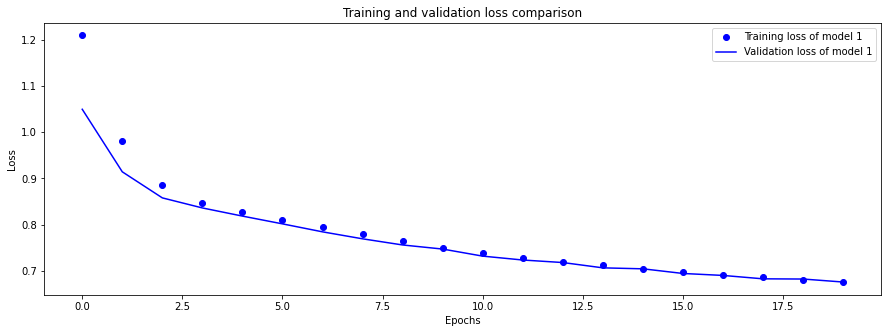

In [ ]:
PlotMultipleLossComparison([loss], [val_loss])

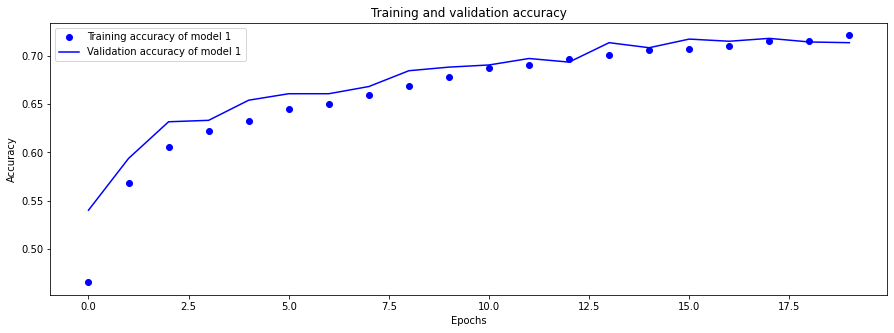

In [ ]:
PlotMultipleAccuracyComparison([acc], [val_acc])

Otrzymany wynik jest zaskakujący, accuracy treningowe jest niższe od walidacyjnego. Może to oznaczać, że skalowanie danych gra tu rolę i prowadzi do underfittingu. 

Sprawdźmy jak model uczy się na danych nieprzeskalowanych:

In [ ]:
prepared_df

,age,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,gender_F,gender_M,class_A,class_B,class_C,class_D
0,27.0,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,0,1,0,0,1,0
1,25.0,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,0,1,1,0,0,0
2,31.0,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,0,1,0,0,1,0
3,32.0,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,0,1,0,1,0,0
4,28.0,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13388,25.0,172.1,71.80,16.2,74.0,141.0,35.8,17.4,47.0,198.0,0,1,0,0,1,0
13389,21.0,179.7,63.90,12.1,74.0,128.0,33.0,1.1,48.0,167.0,0,1,0,0,0,1
13390,39.0,177.2,80.50,20.1,78.0,132.0,63.5,16.4,45.0,229.0,0,1,1,0,0,0
13391,64.0,146.1,57.70,40.4,68.0,121.0,19.3,9.2,0.0,75.0,1,0,0,0,0,1


In [ ]:
X, y = prepared_df.drop(prepared_df.filter(regex='class').columns, axis=1), prepared_df[normalized_df.filter(regex='class').columns]

# set how many records to use
# data_size = len(normalized_df.index)

# In the first step we will split the data in training and remaining dataset
train_data, rem_data, train_targets, rem_targets = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

# split remaining data to test and validation sets
test_size=0.5
val_data, test_data, val_targets, test_targets = train_test_split(rem_data,rem_targets, test_size=test_size, random_state=42) 

In [ ]:
model = build_model()
history = model.fit(train_data,
                    train_targets,
                    epochs=20,
                    batch_size=256,
                    validation_data=(val_data, val_targets))

Epoch 1/20
42/42 [==============================] - 1s 7ms/step - loss: 3.2110 - accuracy: 0.3646 - val_loss: 3.5269 - val_accuracy: 0.3652
Epoch 2/20
42/42 [==============================] - 0s 3ms/step - loss: 2.2443 - accuracy: 0.3946 - val_loss: 1.7336 - val_accuracy: 0.4197
Epoch 3/20
42/42 [==============================] - 0s 3ms/step - loss: 2.0611 - accuracy: 0.4308 - val_loss: 1.5338 - val_accuracy: 0.4122
Epoch 4/20
42/42 [==============================] - 0s 3ms/step - loss: 1.9882 - accuracy: 0.4245 - val_loss: 1.6249 - val_accuracy: 0.4018
Epoch 5/20
42/42 [==============================] - 0s 3ms/step - loss: 1.8215 - accuracy: 0.4501 - val_loss: 2.3836 - val_accuracy: 0.3928
Epoch 6/20
42/42 [==============================] - 0s 3ms/step - loss: 1.8179 - accuracy: 0.4664 - val_loss: 1.4591 - val_accuracy: 0.4839
Epoch 7/20
42/42 [==============================] - 0s 3ms/step - loss: 1.7945 - accuracy: 0.4710 - val_loss: 1.4543 - val_accuracy: 0.4003
Epoch 8/20
42/42 [==

In [ ]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

all_accs.append(acc)
all_val_accs.append(val_acc)
all_losses.append(loss)
all_val_losses.append(val_loss)

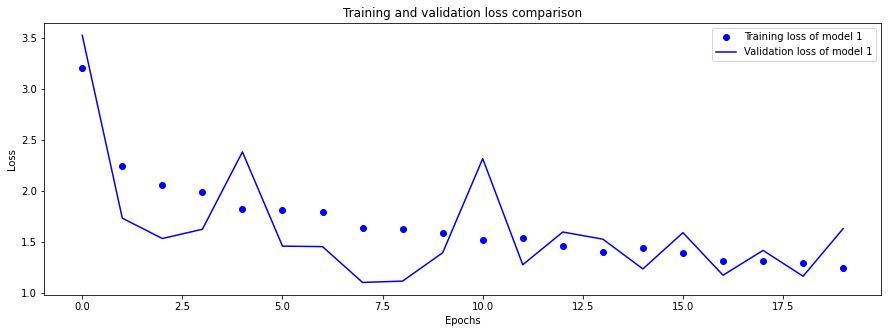

In [ ]:
PlotMultipleLossComparison([loss], [val_loss])

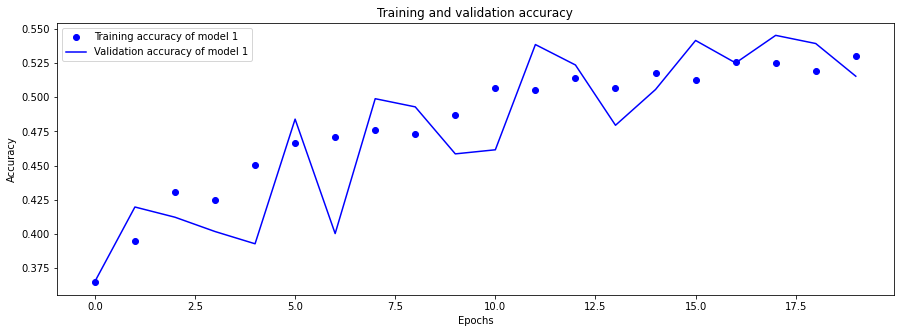

In [ ]:
PlotMultipleAccuracyComparison([acc], [val_acc])

Brak skalowania danych jedynie pogorszył wyniki accuracy oraz loss, lecz nadal wyglądają one podobnie do tych ze skalowaniem.

Pora powrócić do skalowanych danych i zmienić architekturę sieci oraz ilość epok.

In [ ]:
X, y = normalized_df.drop(normalized_df.filter(regex='class').columns, axis=1), normalized_df[normalized_df.filter(regex='class').columns]

# set how many records to use
# data_size = len(normalized_df.index)

# In the first step we will split the data in training and remaining dataset
train_data, rem_data, train_targets, rem_targets = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

# split remaining data to test and validation sets
test_size=0.5
val_data, test_data, val_targets, test_targets = train_test_split(rem_data,rem_targets, test_size=test_size, random_state=42) 

Spróbujmy zwiększyć ilość epok w tym samym modelu.

In [ ]:
model = build_model()
history = model.fit(train_data,
                    train_targets,
                    epochs=50,
                    batch_size=16,
                    validation_data=(val_data, val_targets))

Epoch 1/50
670/670 [==============================] - 2s 2ms/step - loss: 0.9218 - accuracy: 0.5931 - val_loss: 0.8057 - val_accuracy: 0.6438
Epoch 2/50
670/670 [==============================] - 1s 2ms/step - loss: 0.7718 - accuracy: 0.6648 - val_loss: 0.7425 - val_accuracy: 0.6886
Epoch 3/50
670/670 [==============================] - 1s 2ms/step - loss: 0.7212 - accuracy: 0.6951 - val_loss: 0.7101 - val_accuracy: 0.7132
Epoch 4/50
670/670 [==============================] - 1s 2ms/step - loss: 0.6937 - accuracy: 0.7098 - val_loss: 0.6795 - val_accuracy: 0.7244
Epoch 5/50
670/670 [==============================] - 1s 2ms/step - loss: 0.6734 - accuracy: 0.7223 - val_loss: 0.6613 - val_accuracy: 0.7184
Epoch 6/50
670/670 [==============================] - 1s 2ms/step - loss: 0.6578 - accuracy: 0.7304 - val_loss: 0.6532 - val_accuracy: 0.7356
Epoch 7/50
670/670 [==============================] - 1s 2ms/step - loss: 0.6474 - accuracy: 0.7304 - val_loss: 0.6401 - val_accuracy: 0.7334
Epoch 

In [ ]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

all_accs.append(acc)
all_val_accs.append(val_acc)
all_losses.append(loss)
all_val_losses.append(val_loss)

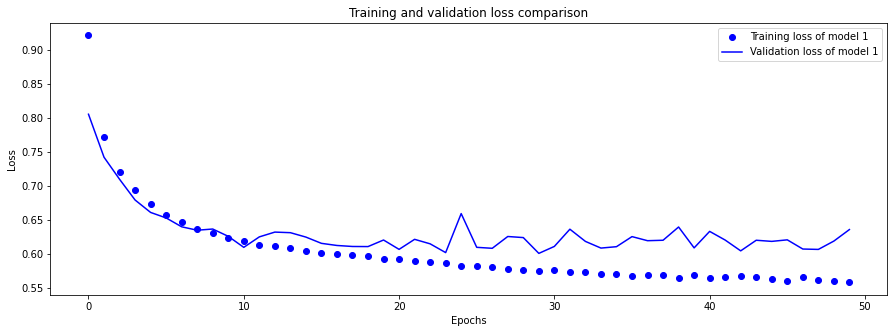

In [ ]:
PlotMultipleLossComparison([loss], [val_loss])

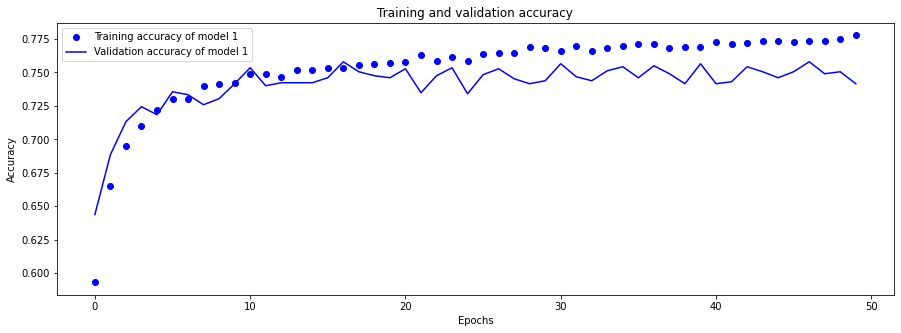

In [ ]:
PlotMultipleAccuracyComparison([acc], [val_acc])

 Do około 10 epoki accuracy oraz loss zarówno w zbiorze treningowym jak i walidacyjnym są takie same - występuje underfitting.

#### Kolejny model

In [ ]:
no_classes = 4

def build_model():
    # Because we will need to instantiate the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(128, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(no_classes, activation='softmax'))
    model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])    
    return model

In [ ]:
model = build_model()
history = model.fit(train_data,
                    train_targets,
                    epochs=100,
                    batch_size=256,
                    validation_data=(val_data, val_targets))

Epoch 1/100
42/42 [==============================] - 1s 8ms/step - loss: 1.0513 - accuracy: 0.5280 - val_loss: 0.8828 - val_accuracy: 0.6258
Epoch 2/100
42/42 [==============================] - 0s 4ms/step - loss: 0.8427 - accuracy: 0.6302 - val_loss: 0.8192 - val_accuracy: 0.6497
Epoch 3/100
42/42 [==============================] - 0s 5ms/step - loss: 0.8001 - accuracy: 0.6499 - val_loss: 0.7917 - val_accuracy: 0.6639
Epoch 4/100
42/42 [==============================] - 0s 10ms/step - loss: 0.7677 - accuracy: 0.6699 - val_loss: 0.7716 - val_accuracy: 0.6692
Epoch 5/100
42/42 [==============================] - 1s 12ms/step - loss: 0.7442 - accuracy: 0.6863 - val_loss: 0.7263 - val_accuracy: 0.7110
Epoch 6/100
42/42 [==============================] - 0s 10ms/step - loss: 0.7229 - accuracy: 0.6954 - val_loss: 0.7373 - val_accuracy: 0.6759
Epoch 7/100
42/42 [==============================] - 0s 7ms/step - loss: 0.7047 - accuracy: 0.7098 - val_loss: 0.7042 - val_accuracy: 0.7058
Epoch 8/10

In [ ]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

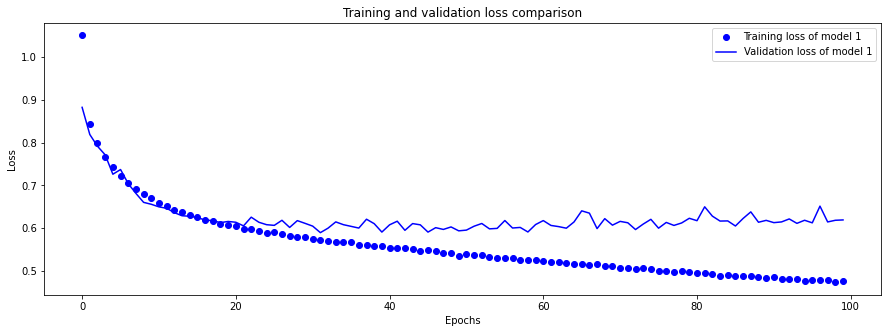

In [ ]:
PlotMultipleLossComparison([loss], [val_loss])

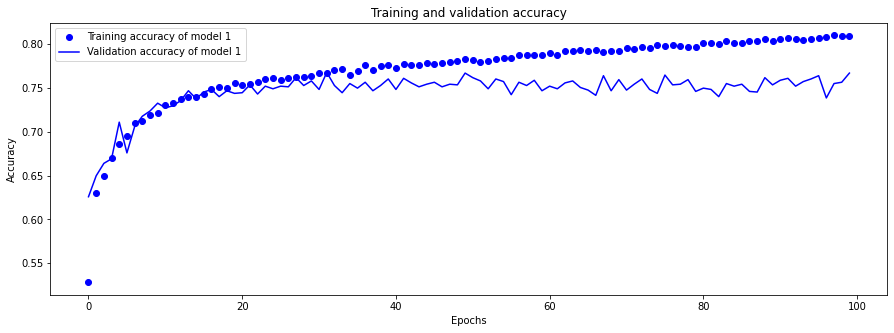

In [ ]:
PlotMultipleAccuracyComparison([acc], [val_acc])

Nadal wyniki są podobne - zwiększmy sieć jeszcze bardziej.

In [ ]:
def build_model():
    # Because we will need to instantiate the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(512, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(no_classes, activation='softmax'))
    model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])    
    return model

In [ ]:
model = build_model()
history = model.fit(train_data,
                    train_targets,
                    epochs=200,
                    batch_size=128,
                    validation_data=(val_data, val_targets))

Epoch 1/200
84/84 [==============================] - 2s 18ms/step - loss: 0.9343 - accuracy: 0.5812 - val_loss: 0.8022 - val_accuracy: 0.6438
Epoch 2/200
84/84 [==============================] - 1s 15ms/step - loss: 0.7733 - accuracy: 0.6618 - val_loss: 0.7181 - val_accuracy: 0.7028
Epoch 3/200
84/84 [==============================] - 1s 16ms/step - loss: 0.7089 - accuracy: 0.6995 - val_loss: 0.6407 - val_accuracy: 0.7319
Epoch 4/200
84/84 [==============================] - 1s 15ms/step - loss: 0.6734 - accuracy: 0.7154 - val_loss: 0.7333 - val_accuracy: 0.6901
Epoch 5/200
84/84 [==============================] - 1s 15ms/step - loss: 0.6566 - accuracy: 0.7205 - val_loss: 0.6290 - val_accuracy: 0.7371
Epoch 6/200
84/84 [==============================] - 1s 15ms/step - loss: 0.6382 - accuracy: 0.7342 - val_loss: 0.6337 - val_accuracy: 0.7311
Epoch 7/200
84/84 [==============================] - 1s 16ms/step - loss: 0.6295 - accuracy: 0.7399 - val_loss: 0.7618 - val_accuracy: 0.6796
Epoch 

In [ ]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

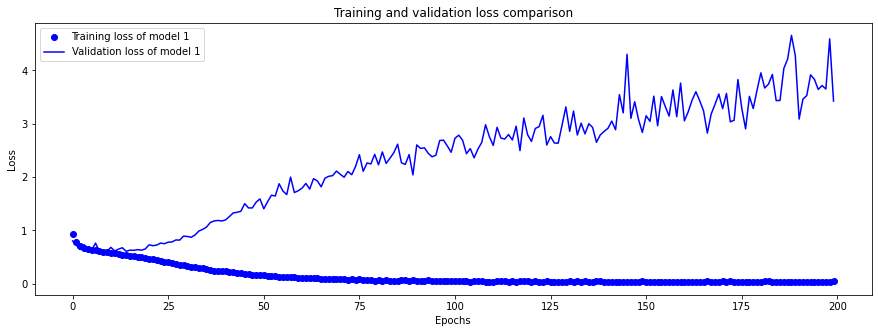

In [ ]:
PlotMultipleLossComparison([loss], [val_loss])

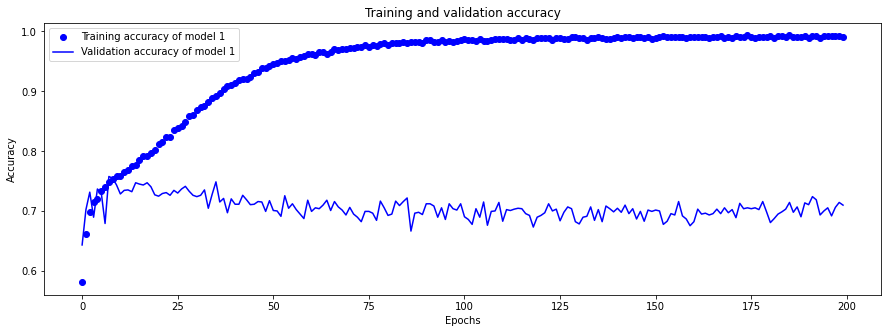

In [ ]:
PlotMultipleAccuracyComparison([acc], [val_acc])

Dla tej sieci widać dość drastyczną różnicę - od około 10 epoki następuje "rajd do sufitu" treningowego accuracy, a loss spada prawie do 0. Widać, że uczenie złożonej sieci przez dużą długi czas dość szybko doprowadza do overfittu.

Sprawdźmy jakie wyniki otrzymamy po zastosowaniu Early Stopping podczas uczenia tego modelu. 

In [1]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [20]:
def build_model():
    # Because we will need to instantiate the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(512, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(no_classes, activation='softmax'))
    model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])    
    return model

In [21]:
model = build_model()
history = model.fit(train_data,
                    train_targets,
                    epochs=100,
                    batch_size=256,
                    validation_data=(val_data, val_targets),
                    callbacks=[early_stopping])

Epoch 1/100
42/42 [==============================] - 5s 58ms/step - loss: 1.0069 - accuracy: 0.5268 - val_loss: 0.8256 - val_accuracy: 0.6400
Epoch 2/100
42/42 [==============================] - 2s 44ms/step - loss: 0.8384 - accuracy: 0.6304 - val_loss: 0.7585 - val_accuracy: 0.6677
Epoch 3/100
42/42 [==============================] - 2s 53ms/step - loss: 0.7752 - accuracy: 0.6653 - val_loss: 0.7162 - val_accuracy: 0.6863
Epoch 4/100
42/42 [==============================] - 1s 24ms/step - loss: 0.7196 - accuracy: 0.6915 - val_loss: 0.6604 - val_accuracy: 0.7132
Epoch 5/100
42/42 [==============================] - 1s 23ms/step - loss: 0.7014 - accuracy: 0.7058 - val_loss: 0.6731 - val_accuracy: 0.7110
Epoch 6/100
42/42 [==============================] - 1s 23ms/step - loss: 0.6775 - accuracy: 0.7154 - val_loss: 0.6873 - val_accuracy: 0.7102
Epoch 7/100
42/42 [==============================] - 1s 23ms/step - loss: 0.6541 - accuracy: 0.7257 - val_loss: 0.6712 - val_accuracy: 0.7252
Epoch 

In [24]:
test_loss, test_accuracy = model.evaluate(test_data, test_targets)
test_accuracy

42/42 [==============================] - 0s 6ms/step - loss: 0.6889 - accuracy: 0.7440


0.7440298795700073

42/42 [==============================] - 0s 6ms/step


Text(0.5, 1.0, 'Confusion Matrix')

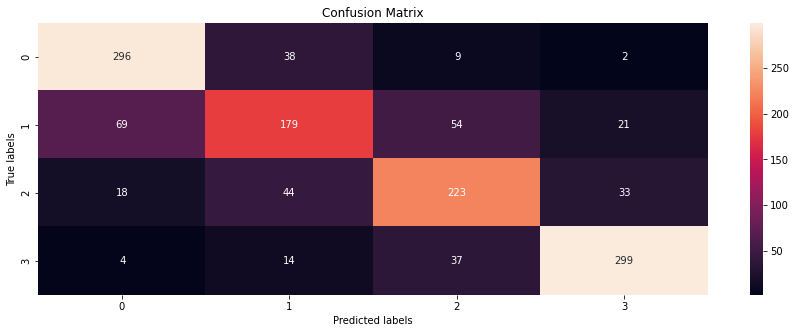

In [35]:
from sklearn.metrics import confusion_matrix 
import seaborn as sns

predicted_targets = model.predict(test_data)

# cm = confusion_matrix(test_targets, predicted_targets)
cm = confusion_matrix(test_targets.values.argmax(axis=1), predicted_targets.argmax(axis=1))

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax=ax,fmt='2g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

Wyniki dla tego datasetu nie są najgorsze, lecz warto sprawdzić też inne architektury. Najwięcej pomyłek występuje w okolicach klasy 1 i jest to wynik sensowny, ponieważ najtrudniej przydzielić klasy sprawności osobom nie znajdującym się w skrajnych przypadkach (najlepszej lub najgorszej formie). 

In [36]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

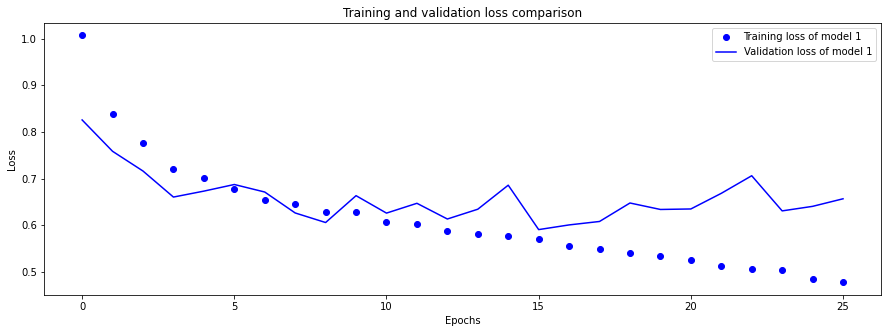

In [37]:
PlotMultipleLossComparison([loss], [val_loss])

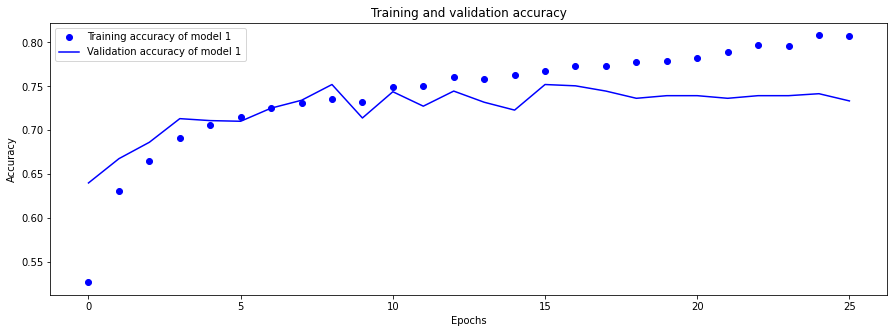

In [38]:
PlotMultipleAccuracyComparison([acc], [val_acc])

Strata na zbiorze treningowym oraz walidacyjnym powoli zaczynała powoli się rozbiegać.

In [54]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)

In [55]:
def build_model():
    # Because we will need to instantiate the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(512, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(no_classes, activation='softmax'))
    model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])    
    return model

In [56]:
model = build_model()
history = model.fit(train_data,
                    train_targets,
                    epochs=100,
                    batch_size=256,
                    validation_data=(val_data, val_targets),
                    callbacks=[early_stopping])

Epoch 1/100
42/42 [==============================] - 2s 18ms/step - loss: 0.9744 - accuracy: 0.5385 - val_loss: 0.8965 - val_accuracy: 0.5818
Epoch 2/100
42/42 [==============================] - 1s 14ms/step - loss: 0.8216 - accuracy: 0.6343 - val_loss: 0.7462 - val_accuracy: 0.6811
Epoch 3/100
42/42 [==============================] - 1s 14ms/step - loss: 0.7541 - accuracy: 0.6731 - val_loss: 0.7434 - val_accuracy: 0.6886
Epoch 4/100
42/42 [==============================] - 1s 14ms/step - loss: 0.7109 - accuracy: 0.6957 - val_loss: 0.6885 - val_accuracy: 0.7043
Epoch 5/100
42/42 [==============================] - 1s 14ms/step - loss: 0.6845 - accuracy: 0.7079 - val_loss: 0.6956 - val_accuracy: 0.7087
Epoch 6/100
42/42 [==============================] - 1s 14ms/step - loss: 0.6647 - accuracy: 0.7222 - val_loss: 0.6270 - val_accuracy: 0.7386
Epoch 7/100
42/42 [==============================] - 1s 13ms/step - loss: 0.6597 - accuracy: 0.7225 - val_loss: 0.6334 - val_accuracy: 0.7282
Epoch 

In [57]:
test_loss, test_accuracy = model.evaluate(test_data, test_targets)
test_accuracy

42/42 [==============================] - 0s 3ms/step - loss: 0.6239 - accuracy: 0.7463


0.746268630027771

42/42 [==============================] - 0s 3ms/step


Text(0.5, 1.0, 'Confusion Matrix')

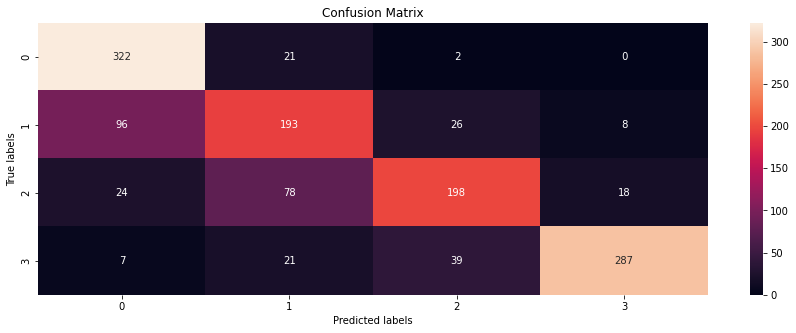

In [58]:
from sklearn.metrics import confusion_matrix 
import seaborn as sns

predicted_targets = model.predict(test_data)

# cm = confusion_matrix(test_targets, predicted_targets)
cm = confusion_matrix(test_targets.values.argmax(axis=1), predicted_targets.argmax(axis=1))

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax=ax,fmt='2g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

Usunięcie jednej warstwy ukrytej o 512 neuronach oraz zmniejszenie patience z 10 do 8 epok spowodowało delikatne polepszenie się wyników.

Jak widać na `confusion matrix` dopasowania klas są na niezłym poziomie, lecz sieć nadal pomyliła sporą część osób należących do klasy 1 przyporządkowując im klasę 0 oraz osób należących do klasy 2 przyporządkowała klasę 1. 

In [59]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

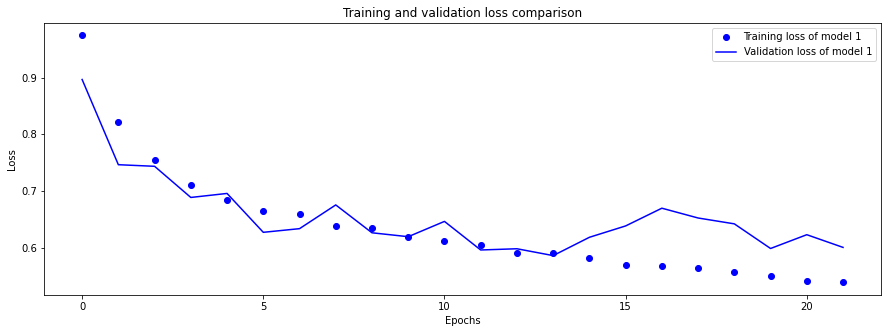

In [60]:
PlotMultipleLossComparison([loss], [val_loss])

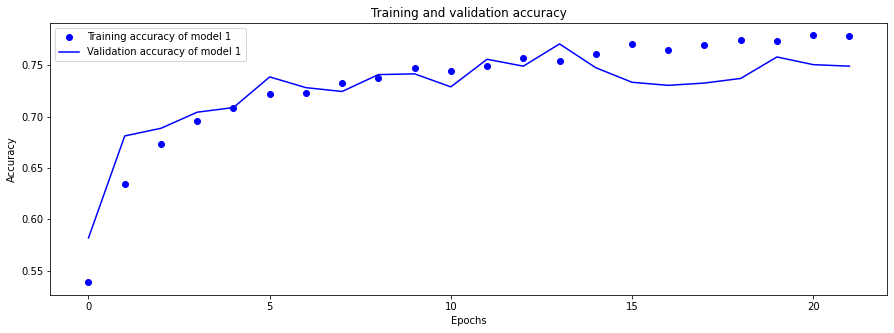

In [61]:
PlotMultipleAccuracyComparison([acc], [val_acc])